In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")
# Librerías comunes (ejecuta una vez)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.stattools import coint
from scipy.stats import zscore
from scipy.signal import find_peaks
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from arch import arch_model
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12,5)


Recopilación de los datos de BBVA y Banco Santander de yahoo finances. ddesde el 1 de enero de 2000 hasta la fecha

In [113]:
import yfinance as yf
import pandas as pd
BBVA_ticker = "BBVA.MC" 
SANTANDER_ticker = "SAN.MC"

start_date = "2000-01-01"
end_date = "2025-10-31"   # ✅ 31 de octubre de 2025

# Descargar datos históricos
BBVA_data = yf.download(BBVA_ticker, start=start_date, end=end_date, auto_adjust=True, actions=True)
SANTANDER_data = yf.download(SANTANDER_ticker, start=start_date, end=end_date, auto_adjust=True, actions=True)

print("BBVA Data:")
print(BBVA_data.head())
print("\nSantander Data:")
print(SANTANDER_data.head())

# Guardar CSV individuales (opcional)
BBVA_data.to_csv("bbva.csv")
SANTANDER_data.to_csv("santander.csv")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

BBVA Data:
Price          Close Dividends      High       Low      Open Stock Splits  \
Ticker       BBVA.MC   BBVA.MC   BBVA.MC   BBVA.MC   BBVA.MC      BBVA.MC   
Date                                                                        
2000-01-03  4.040036       0.0  4.079924  4.031489  4.059980          0.0   
2000-01-04  3.934619       0.0  4.014394  3.920373  3.988752          0.0   
2000-01-05  3.846296       0.0  3.917523  3.829201  3.897579          0.0   
2000-01-06  3.846296       0.0  3.846296  3.846296  3.846296          0.0   
2000-01-07  3.894730       0.0  3.928919  3.854842  3.928919          0.0   

Price         Volume  
Ticker       BBVA.MC  
Date                  
2000-01-03   8244257  
2000-01-04   8522096  
2000-01-05  12159826  
2000-01-06         0  
2000-01-07  62261944  

Santander Data:
Price          Close Dividends      High       Low      Open Stock Splits  \
Ticker        SAN.MC    SAN.MC    SAN.MC    SAN.MC    SAN.MC       SAN.MC   
Date             

Descarga de macrovariables en un dataset

In [114]:
import pandas_datareader.data as pdr


In [115]:
import pandas as pd
import yfinance as yf
import pandas_datareader.data as pdr

start_date = "2000-01-01"
end_date = "2025-10-31"   # ✅ 31 de octubre de 2025

macro_vars = {
    "FEDFUNDS": "tasa_interes",               
    "CPIAUCSL": "inflacion",                  
    "GDPC1": "PIB",                           
    "UNRATE": "desempleo",                    
    "DEXUSEU": "tipo_cambio",                 
    "M2SL": "liquidez_M2",                    
    "PALLFNFINDEXQ": "materias_primas",       
    "GS10": "politica_monetaria",             
    "BAMLH0A0HYM2": "sentimiento_global"      
}

macro_data = pd.DataFrame()

# Datos FRED (EEUU)
for fred_code, name in macro_vars.items():
    try:
        df = pdr.DataReader(fred_code, 'fred', start_date, end_date)
        df.rename(columns={fred_code: name}, inplace=True)
        macro_data = pd.concat([macro_data, df], axis=1)
    except Exception as e:
        print(f"No se pudo descargar {fred_code}: {e}")

# Datos Eurozona y España desde FRED
euro_vars = {}

try:
    euro_infl = pdr.DataReader('CP0000EZ19M086NEST', 'fred', start_date, end_date)  # Inflación Eurozona
    euro_vars["inflacion_eurozona"] = euro_infl
except Exception as e:
    print(f"No se pudo descargar inflación Eurozona: {e}")

try:
    unemp_spain = pdr.DataReader('LRHUTTTTESM156S', 'fred', start_date, end_date)   # Desempleo España
    euro_vars["desempleo_espana"] = unemp_spain
except Exception as e:
    print(f"No se pudo descargar desempleo España: {e}")

euro_data = pd.concat(euro_vars.values(), axis=1) if euro_vars else pd.DataFrame()
if not euro_data.empty:
    euro_data.columns = euro_vars.keys()

# Descargar VIX
VIX_data = yf.download("^VIX", start=start_date, end=end_date)[["Close"]]
VIX_data.rename(columns={"Close": "VIX"}, inplace=True)

# Unir todo
macro_data = macro_data.resample('D').ffill()
euro_data = euro_data.resample('D').ffill()
VIX_data = VIX_data.resample('D').ffill()

global_macro = macro_data.join([euro_data, VIX_data], how="outer").resample('D').ffill()

print("✅ Dataset combinado creado correctamente.")
print(global_macro.tail())


[*********************100%***********************]  1 of 1 completed

✅ Dataset combinado creado correctamente.
            tasa_interes  inflacion  PIB  desempleo  tipo_cambio  liquidez_M2  \
2025-10-27           NaN        NaN  NaN        NaN       1.1636          NaN   
2025-10-28           NaN        NaN  NaN        NaN       1.1659          NaN   
2025-10-29           NaN        NaN  NaN        NaN       1.1664          NaN   
2025-10-30           NaN        NaN  NaN        NaN       1.1564          NaN   
2025-10-31           NaN        NaN  NaN        NaN       1.1541          NaN   

            materias_primas  politica_monetaria  sentimiento_global  \
2025-10-27              NaN                 NaN                2.80   
2025-10-28              NaN                 NaN                2.82   
2025-10-29              NaN                 NaN                2.76   
2025-10-30              NaN                 NaN                2.85   
2025-10-31              NaN                 NaN                2.94   

            inflacion_eurozona  desempleo_es

Combinar macrovariables con el dataset de BBVA 



In [116]:
# Aplanar las columnas
BBVA_data.columns = ['_'.join(col).strip() for col in BBVA_data.columns.values]

# Verificar resultado
print(BBVA_data.head())
print(BBVA_data.columns)


            Close_BBVA.MC  Dividends_BBVA.MC  High_BBVA.MC  Low_BBVA.MC  \
Date                                                                      
2000-01-03       4.040036                0.0      4.079924     4.031489   
2000-01-04       3.934619                0.0      4.014394     3.920373   
2000-01-05       3.846296                0.0      3.917523     3.829201   
2000-01-06       3.846296                0.0      3.846296     3.846296   
2000-01-07       3.894730                0.0      3.928919     3.854842   

            Open_BBVA.MC  Stock Splits_BBVA.MC  Volume_BBVA.MC  
Date                                                            
2000-01-03      4.059980                   0.0         8244257  
2000-01-04      3.988752                   0.0         8522096  
2000-01-05      3.897579                   0.0        12159826  
2000-01-06      3.846296                   0.0               0  
2000-01-07      3.928919                   0.0        62261944  
Index(['Close_BBVA.

In [117]:
bbva_full = BBVA_data.join(global_macro, how='left').ffill().dropna()
bbva_full.to_csv("bbva_completo.csv")

Combinar las macrovariables con el dataset de Santander 

In [118]:
# Aplanar columnas multinivel (por ejemplo ('Price', 'Close', 'SAN.MC') → 'Price_Close_SAN.MC')
SANTANDER_data.columns = ['_'.join(col).strip() for col in SANTANDER_data.columns.values]

# Hacer el join con los datos macro
santander_full = SANTANDER_data.join(global_macro, how='left').ffill().dropna()

# Guardar el CSV
santander_full.to_csv("santander_completo.csv")

print("✅ Archivo santander_completo.csv guardado correctamente.")


✅ Archivo santander_completo.csv guardado correctamente.


In [119]:
print("\n✅ Dataset BBVA listo:")
print(bbva_full.head())

print("\n✅ Dataset Santander listo:")
print(santander_full.head())

print("\nColumnas del dataset final:")
print(list(bbva_full.columns))


✅ Dataset BBVA listo:
            Close_BBVA.MC  Dividends_BBVA.MC  High_BBVA.MC  Low_BBVA.MC  \
Date                                                                      
2003-01-01       2.819043                0.0      2.819043     2.819043   
2003-01-02       2.967412                0.0      2.967412     2.819041   
2003-01-03       2.948866                0.0      3.019960     2.939593   
2003-01-06       2.948866                0.0      2.948866     2.948866   
2003-01-07       2.998323                0.0      3.060144     2.989050   

            Open_BBVA.MC  Stock Splits_BBVA.MC  Volume_BBVA.MC  tasa_interes  \
Date                                                                           
2003-01-01      2.819043                   0.0               0          1.24   
2003-01-02      2.967412                   0.0        39035426          1.24   
2003-01-03      2.948866                   0.0        61596325          1.24   
2003-01-06      2.948866                   0.0     

## Análisis de series financieras

#### 0.Preparación y variables útiles

In [120]:
# Suponemos bbva_full y santander_full ya cargados (index datetime)
# También global_macro ya existe (VIX, inflacion_eurozona, desempleo_espana, etc.)

# Asegurar frecuencia diaria y alineación
bbva = bbva_full.copy().asfreq('D').ffill()
san = santander_full.copy().asfreq('D').ffill()
macro = global_macro.copy().asfreq('D').ffill()

# Crear precios y retornos logaritmicos
bbva['log_close'] = np.log(bbva['Close_BBVA.MC'])
san['log_close']  = np.log(san['Close_SAN.MC'])

bbva['ret'] = bbva['log_close'].diff()
san['ret']  = san['log_close'].diff()

# Volatilidad rolling (sd of returns)
window_vol = 21  # 1 mes aprox de trading
bbva['vol_roll'] = bbva['ret'].rolling(window_vol).std() * np.sqrt(252)
san['vol_roll']  = san['ret'].rolling(window_vol).std() * np.sqrt(252)

# Extra: serie de VIX y otras variables en macro (asegúrate que existan)
if 'VIX' not in macro.columns and '^VIX' in macro.columns:
    macro['VIX'] = macro['^VIX']

# Consolidar en un df para análisis conjunto si hace falta
joint = pd.DataFrame({
    'BBVA_Close': bbva['Close_BBVA.MC'],
    'SAN_Close': san['Close_SAN.MC'],
})
joint = joint.join(macro, how='left').ffill()


#### 1. Descomposición STL (BBVA y Santander)

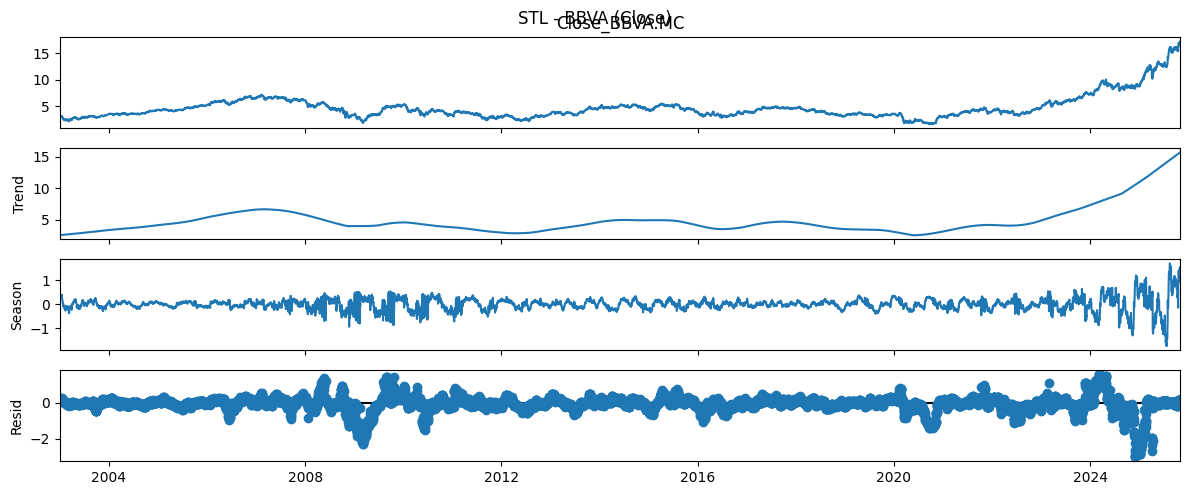

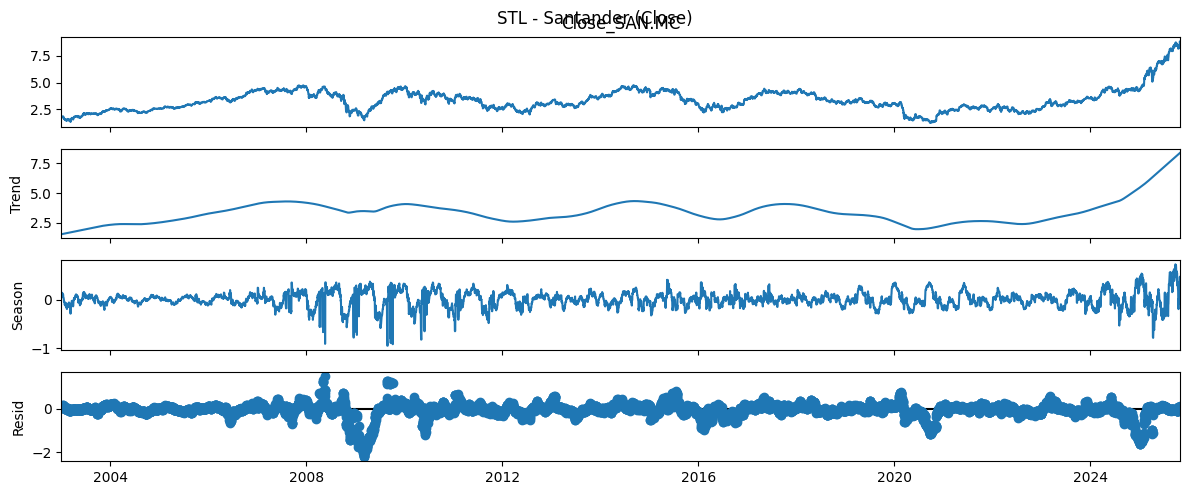

In [121]:
# STL BBVA
stl_bbva = STL(bbva['Close_BBVA.MC'].dropna(), period=252, robust=True).fit()
stl_bbva.plot()
plt.suptitle("STL - BBVA (Close)")
plt.show()

# STL Santander
stl_san = STL(san['Close_SAN.MC'].dropna(), period=252, robust=True).fit()
stl_san.plot()
plt.suptitle("STL - Santander (Close)")
plt.show()


#### Filtro HP (macro: Euribor/IPC/PIB/desempleo)
Explicación: HP separa tendencia larga y ciclo. Para series macro (mensuales o trimestrales) tendrás que ajustar lamb. Para datos diarios usareamos lamb=1600 como punto de partida pero para series macro con baja frecuencia considera lamb mayores (e.g., 129600 para series mensuales — ajusta según frecuencia).

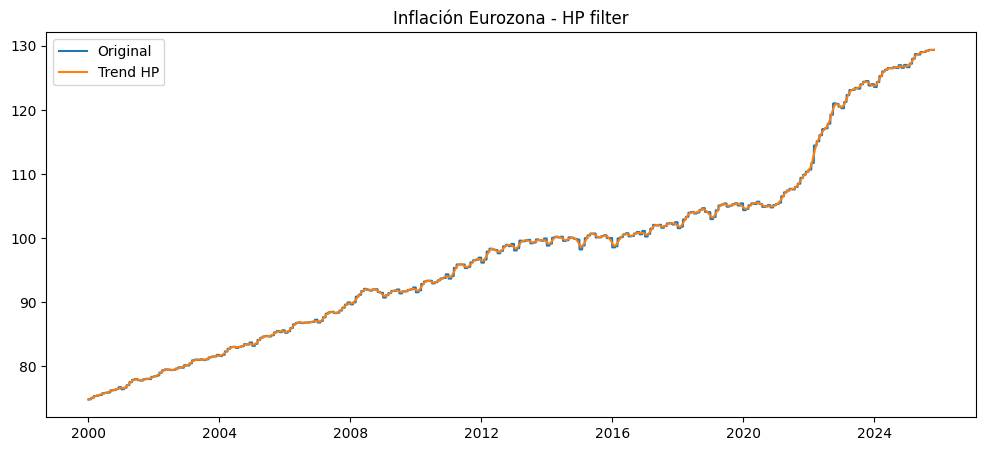

In [122]:
# Ejemplo con inflación Eurozona (si está en macro)
series = macro['inflacion_eurozona'].dropna()
if not series.empty:
    cycle, trend = hpfilter(series, lamb=129600)  # ejemplo para monthly-like series
    plt.figure()
    plt.plot(series.index, series, label='Original')
    plt.plot(trend.index, trend, label='Trend HP')
    plt.title("Inflación Eurozona - HP filter")
    plt.legend()
    plt.show()
else:
    print("No hay serie de 'inflacion_eurozona' en macro.")


Repite para desempleo_espana, Euribor, PIB (ajusta lamb según frecuencia).

#### 3. Detección de picos (VIX, IBEX, Brent, prima de riesgo) — rolling mean + z-score
Explicación: marcador robusto para identificar días de estrés: calculamos z-score usando rolling() y señalamos valores con |z| > umbral.


In [123]:
def detect_peaks_z(serie, window=60, threshold=2.0):
    rm = serie.rolling(window).mean()
    rs = serie.rolling(window).std()
    z = (serie - rm) / rs
    peaks = z.abs() > threshold
    return peaks, z

# Ejemplo VIX (si existe)
if 'VIX' in joint.columns:
    peaks_vix, z_vix = detect_peaks_z(joint['VIX'].dropna(), window=60, threshold=2.0)
    plt.plot(joint['VIX'], label='VIX')
    plt.scatter(joint['VIX'][peaks_vix].index, joint['VIX'][peaks_vix], color='red', label='Peaks')
    plt.title("Picos VIX (zscore rolling)")
    plt.legend()
    plt.show()
else:
    print("No hay VIX en joint.")


No hay VIX en joint.


Haz lo mismo para IBEX (si lo tienes), Brent (si lo tienes) y prima_de_riesgo (o proxy, e.g. spread bonos).

#### 4. Marcar fechas de picos comunes entre variables
Explicación: detectamos picos (boolean) para varias series, sumamos y tomamos fechas donde >= 2 o >=3 series coinciden — eso marca shocks sistémicos.

In [124]:
# Detectar picos para varias series (ajusta nombres según tu macro df)
candidates = {}
for col in ['VIX', 'IBEX_Close', 'Brent', 'prima_riesgo']:  # ajusta a tus columnas
    if col in joint.columns:
        p, _ = detect_peaks_z(joint[col].dropna(), window=60, threshold=2.0)
        candidates[col] = p

# Unir booleans por índice
peaks_df = pd.DataFrame(candidates).fillna(False)
if not peaks_df.empty:
    peaks_df['common_count'] = peaks_df.sum(axis=1)
    common_shocks = peaks_df[peaks_df['common_count'] >= 2]
    print("Fechas con picos simultáneos (>=2 series):")
    print(common_shocks.index.date[:50])
else:
    print("No se detectaron series para comparar picos.")


No se detectaron series para comparar picos.


#### 5.Correlaciones dinámicas.
Explicación: cómo cambian las correlaciones BBVA vs Santander, BBVA vs VIX, etc., a lo largo del tiempo.

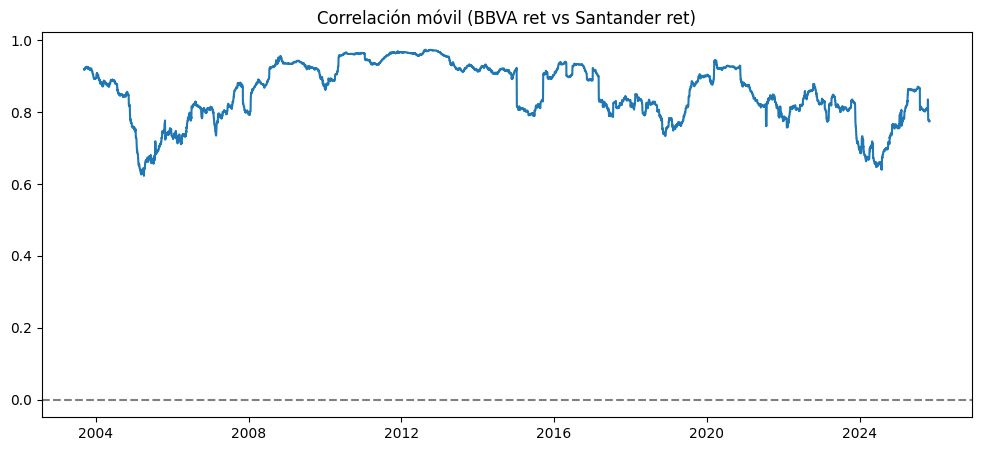

In [125]:
window = 252  # 1 año approx
# BBVA vs Santander closing prices log-returns
corr_bbva_san = bbva['ret'].rolling(window).corr(san['ret'])
plt.plot(corr_bbva_san)
plt.title("Correlación móvil (BBVA ret vs Santander ret)")
plt.axhline(0, linestyle='--', color='gray')
plt.show()

# BBVA vs VIX (ret vs level o ret vs ret)
if 'VIX' in joint.columns:
    corr_bbva_vix = bbva['ret'].rolling(window).corr(joint['VIX'])
    plt.plot(corr_bbva_vix)
    plt.title("Correlación móvil (BBVA ret vs VIX level)")
    plt.show()


ota: VIX es nivel y BBVA es retorno; puedes correlacionar ret con VIX o con ret(VIX) si lo prefieres.

#### 6. Volatilidad: rolling + GARCH
xplicación: estimamos volatilidad condicional con GARCH(1,1) y comparamos con volatilidad rolling.

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -15348.5
Distribution:                  Normal   AIC:                           30704.9
Method:            Maximum Likelihood   BIC:                           30733.0
                                        No. Observations:                 8338
Date:                Sat, Nov 08 2025   Df Residuals:                     8337
Time:                        18:18:03   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0504  1.534e-02      3.288  1.009e-03 [2.

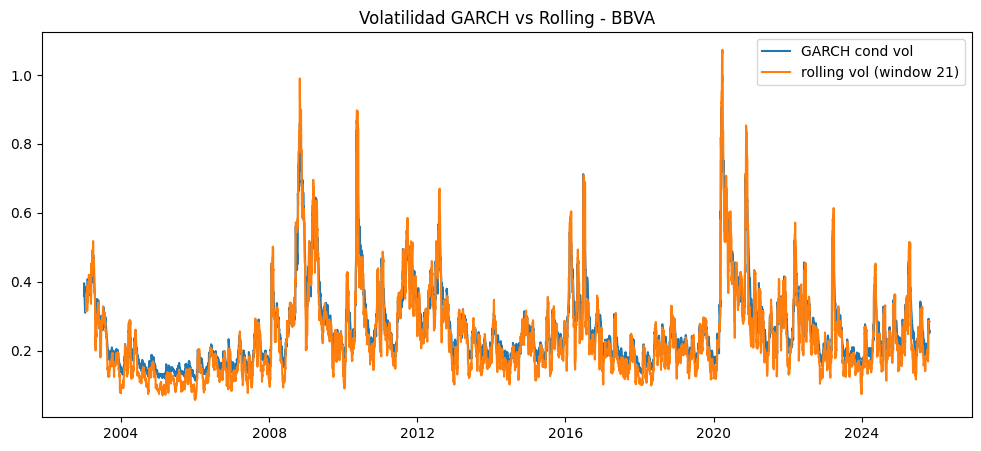

In [126]:
# Rolling vol ya calculada en preparación (vol_roll). Vamos a ajustar GARCH a los retornos de BBVA
bbva_rets = bbva['ret'].dropna()*100  # % returns

# Ajustar GARCH(1,1) (modela var cond)
am = arch_model(bbva_rets, vol='Garch', p=1, q=1, dist='normal')
res = am.fit(disp='off')
print(res.summary())

# Volatilidad condicional estimada (annualized)
cond_vol = res.conditional_volatility / 100 * np.sqrt(252)
plt.plot(cond_vol, label='GARCH cond vol')
plt.plot(bbva['vol_roll'], label='rolling vol (window {})'.format(window_vol))
plt.legend()
plt.title("Volatilidad GARCH vs Rolling - BBVA")
plt.show()


Repite para santander 


#### 7. Cointegración (BBVA vs Santander)
Explicación: testea si existe relación de largo plazo entre los precios (útil para pares trading).

In [127]:
# Usar precios (nivel); quitar NaNs
p1 = bbva['Close_BBVA.MC'].dropna()
p2 = san['Close_SAN.MC'].dropna()
# Alinear
dfp = pd.concat([p1, p2], axis=1).dropna()
score, pvalue, _ = coint(dfp.iloc[:,0], dfp.iloc[:,1])
print("Cointegration test p-value:", pvalue)
if pvalue < 0.05:
    print("Hay cointegración significativa (p < 0.05).")
else:
    print("No hay evidencia fuerte de cointegración.")


Cointegration test p-value: 0.8456421426219347
No hay evidencia fuerte de cointegración.


#### 8.Cross-correlation lag analysis (¿un indicador anticipa a otro?)
Explicación: usar CCF o correlaciones con lags para ver si VIX anticipa movimientos en BBVA, etc.

In [128]:
from statsmodels.tsa.stattools import ccf

# Tomar series limpias y standardize
vix = joint['VIX'].dropna().loc[dfp.index.min():dfp.index.max()] if 'VIX' in joint.columns else None
bbva_ret = bbva['ret'].dropna().loc[dfp.index.min():dfp.index.max()]

if vix is not None:
    # Resample to align and dropna
    tmp = pd.concat([bbva_ret, vix], axis=1).dropna()
    x = (tmp['VIX'] - tmp['VIX'].mean())/tmp['VIX'].std()
    y = (tmp['ret'] - tmp['ret'].mean())/tmp['ret'].std()
    # ccf gives correlation at lags (positive lag => x leads y)
    lags = 30
    c = ccf(x, y)[:lags]
    plt.bar(range(len(c)), c)
    plt.axhline(0, color='k', linestyle='--')
    plt.title("CCF: VIX vs BBVA ret (pos lag => VIX leads BBVA)")
    plt.show()
else:
    print("No VIX para análisis de cross-corr.")


No VIX para análisis de cross-corr.


#### 9. Clusterización de periodos de crisis (PCA + KMeans)
Explicación: transformamos variables de estrés (VIX, vol rol, spreads, returns) a componentes y clusterizamos para identificar regimes (tranquilo vs estresado).

Cluster 0 - count: 1228
Cluster 1 - count: 6165
Cluster 2 - count: 925


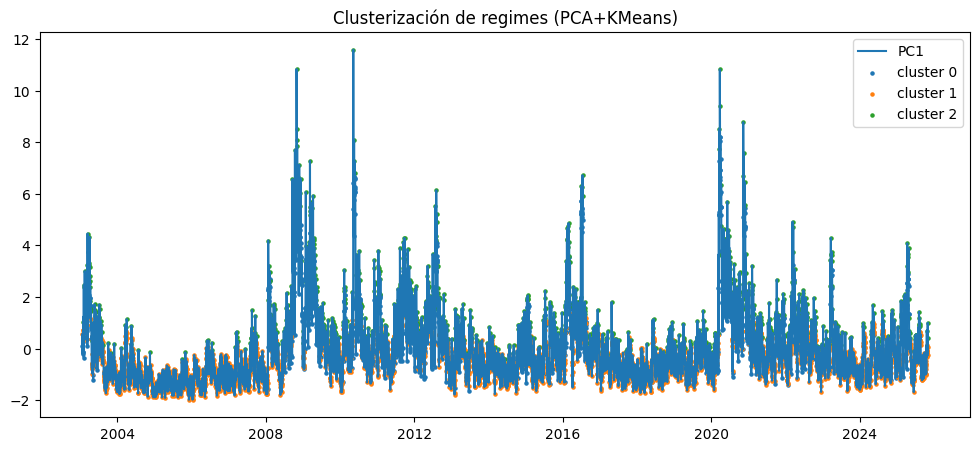

In [129]:
# Construir matrix de features por día (ajusta columnas)
features = pd.DataFrame({
    'BBVA_ret': bbva['ret'],
    'SAN_ret': san['ret'],
    'BBVA_vol': bbva['vol_roll'],
    'SAN_vol': san['vol_roll'],
})
# Añadir VIX y prima_riesgo si existen
for col in ['VIX','prima_riesgo','Brent']:
    if col in joint.columns:
        features[col] = joint[col]

features = features.dropna()

# Standardize
X = (features - features.mean()) / features.std()

# PCA para reducción
pca = PCA(n_components=3)
Z = pca.fit_transform(X)

# KMeans (2 or 3 clusters)
k = 3
km = KMeans(n_clusters=k, random_state=42).fit(Z)
labels = km.labels_

# Añadir etiquetas al df y ver periodos
features['cluster'] = labels
for i in range(k):
    print(f"Cluster {i} - count:", (features['cluster']==i).sum())

# Plot clusters on first PCA component timeline
plt.plot(pd.to_datetime(features.index), Z[:,0], label='PC1')
for i in range(k):
    idx = features.index[features['cluster']==i]
    plt.scatter(idx, Z[features['cluster']==i,0], s=5, label=f'cluster {i}')
plt.legend()
plt.title("Clusterización de regimes (PCA+KMeans)")
plt.show()


#### 10. Resumen de fechas críticas y salida para informe
Explicación: creamos una tabla con las fechas donde múltiples indicadores marcaron picos (vinculable a eventos históricos).

In [130]:
# Generar tabla de fechas críticas (union de picos de BBVA, SAN, VIX y prima)
peaks_list = {}
for name, ser in [('BBVA', bbva['ret']), ('SAN', san['ret']), ('VIX', joint.get('VIX'))]:
    if ser is not None:
        p, z = detect_peaks_z(ser.abs(), window=60, threshold=2.0)
        peaks_list[name] = p

peaks_tbl = pd.DataFrame(peaks_list).fillna(False)
peaks_tbl['count'] = peaks_tbl.sum(axis=1)
critical_dates = peaks_tbl[peaks_tbl['count'] >= 2].index
print("Fechas críticas detectadas (ejemplos):")
print(critical_dates.date[:50])

# Guardar CSV con las fechas y qué series hicieron pico
peaks_tbl.to_csv("peaks_by_series.csv")

Fechas críticas detectadas (ejemplos):
[datetime.date(2003, 3, 13) datetime.date(2003, 3, 14)
 datetime.date(2003, 5, 19) datetime.date(2003, 10, 3)
 datetime.date(2003, 11, 17) datetime.date(2003, 12, 1)
 datetime.date(2004, 1, 2) datetime.date(2004, 1, 29)
 datetime.date(2004, 2, 6) datetime.date(2004, 3, 11)
 datetime.date(2004, 3, 15) datetime.date(2004, 3, 17)
 datetime.date(2004, 5, 10) datetime.date(2004, 5, 19)
 datetime.date(2004, 7, 27) datetime.date(2004, 10, 1)
 datetime.date(2004, 10, 4) datetime.date(2004, 11, 17)
 datetime.date(2005, 3, 16) datetime.date(2005, 4, 15)
 datetime.date(2005, 7, 7) datetime.date(2005, 9, 26)
 datetime.date(2005, 9, 28) datetime.date(2005, 10, 31)
 datetime.date(2006, 1, 25) datetime.date(2006, 1, 26)
 datetime.date(2006, 2, 22) datetime.date(2006, 4, 21)
 datetime.date(2006, 5, 12) datetime.date(2006, 5, 17)
 datetime.date(2006, 5, 22) datetime.date(2006, 6, 8)
 datetime.date(2006, 10, 17) datetime.date(2006, 11, 24)
 datetime.date(2006, 11, 

#### Entrenamiento y modelado para BBVA 

In [131]:
import pandas as pd

BBVA_data = pd.read_csv("bbva_completo.csv")
SANTANDER_data = pd.read_csv("santander_completo.csv")

print(BBVA_data.columns)
print(SANTANDER_data.columns)


Index(['Date', 'Close_BBVA.MC', 'Dividends_BBVA.MC', 'High_BBVA.MC',
       'Low_BBVA.MC', 'Open_BBVA.MC', 'Stock Splits_BBVA.MC', 'Volume_BBVA.MC',
       'tasa_interes', 'inflacion', 'PIB', 'desempleo', 'tipo_cambio',
       'liquidez_M2', 'materias_primas', 'politica_monetaria',
       'sentimiento_global', 'inflacion_eurozona', 'desempleo_espana',
       '('VIX', '^VIX')'],
      dtype='object')
Index(['Date', 'Close_SAN.MC', 'Dividends_SAN.MC', 'High_SAN.MC', 'Low_SAN.MC',
       'Open_SAN.MC', 'Stock Splits_SAN.MC', 'Volume_SAN.MC', 'tasa_interes',
       'inflacion', 'PIB', 'desempleo', 'tipo_cambio', 'liquidez_M2',
       'materias_primas', 'politica_monetaria', 'sentimiento_global',
       'inflacion_eurozona', 'desempleo_espana', '('VIX', '^VIX')'],
      dtype='object')


Entrenando modelos para BBVA con 5852 registros...

🔹 Entrenando modelo SimpleRNN para BBVA
Epoch 1/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014
Epoch 2/80
173/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7389e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.7640e-04
Epoch 3/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4659e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.5132e-04
Epoch 4/80
173/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3745e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4335e-04
Epoch 5/80
171/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3097e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3771e-04
Epoch 6/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2563e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3356e-04
Epoch 7/80
169/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2418e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3124e-04
Epoch 8/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2305e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2754e-04
Epoch 9/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1989e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2422e-04
Epoch 10/80
166/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1733e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2133e-04
Epoch 11/80
173/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1577e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1967e-04
Epoch 12/80
172/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1550e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1872e-04
Epoch 13/80
171/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1388e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1688e-04
Epoch 14/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1381e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1630e-04
Epoch 15/80
167/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1236e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1544e-04
Epoch 16/80
174/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1249e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1515e-04
Epoch 17/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1171e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1401e-04
Epoch 18/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1406e-04
Epoch 19/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1099e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1365e-04
Epoch 20/80
171/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1096e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1327e-04
Epoch 21/80
169/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1106e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1286e-04
Epoch 22/80
172/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1053e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1245e-04
Epoch 23/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1268e-04
Epoch 24/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1052e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1223e-04
Epoch 25/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1300e-04
Epoch 26/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1042e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1207e-04
Epoch 27/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1261e-04
Epoch 28/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1218e-04
Epoch 29/80
173/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1058e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1199e-04
Epoch 30/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1219e-04
Epoch 31/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1030e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1150e-04
Epoch 32/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1173e-04
Epoch 33/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1266e-04
Epoch 34/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1082e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1138e-04
Epoch 35/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1089e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1137e-04
Epoch 36/80
174/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1070e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1134e-04
Epoch 37/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1140e-04
Epoch 38/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1039e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1090e-04
Epoch 39/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1126e-04
Epoch 40/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1105e-04
Epoch 41/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0990e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1033e-04
Epoch 42/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1063e-04
Epoch 43/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0991e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1018e-04
Epoch 44/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1087e-04
Epoch 45/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1014e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1000e-04
Epoch 46/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1031e-04
Epoch 47/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1028e-04
Epoch 48/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1009e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0995e-04
Epoch 49/80
173/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0992e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0982e-04
Epoch 50/80
169/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0962e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0973e-04
Epoch 51/80
168/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0961e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0940e-04
Epoch 52/80
168/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0956e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0936e-04
Epoch 53/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0946e-04
Epoch 54/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0941e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0930e-04
Epoch 55/80
168/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0931e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0916e-04
Epoch 56/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0906e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0886e-04
Epoch 57/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0948e-04
Epoch 58/80
171/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0916e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0871e-04
Epoch 59/80
172/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0917e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0860e-04
Epoch 60/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0906e-04
Epoch 61/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0881e-04
Epoch 62/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0871e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0802e-04
Epoch 63/80
174/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0862e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0794e-04
Epoch 64/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0835e-04
Epoch 65/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0805e-04
Epoch 66/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0841e-04
Epoch 67/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0812e-04
Epoch 68/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0836e-04
Epoch 69/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0802e-04
Epoch 70/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0841e-04
Epoch 71/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0829e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


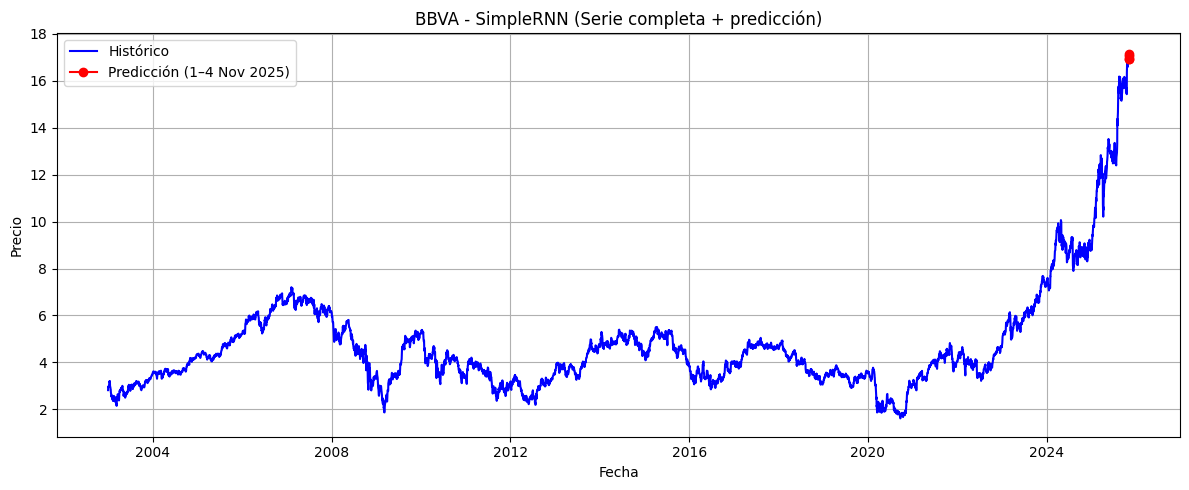

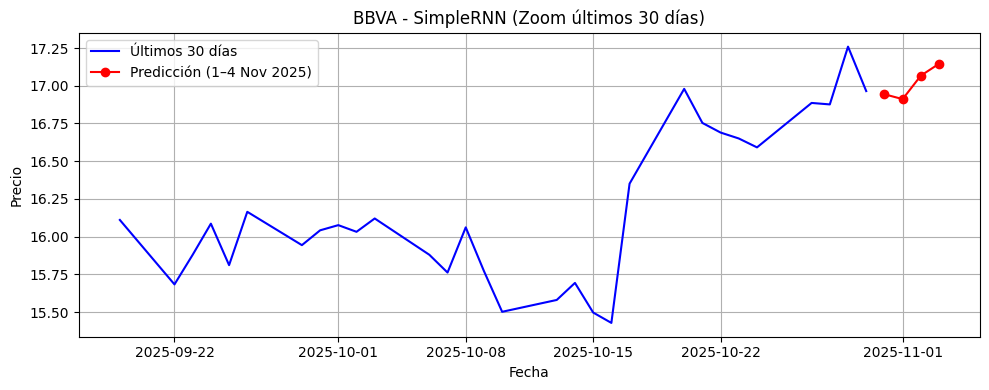


🔹 Entrenando modelo LSTM para BBVA
Epoch 1/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0102

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0027
Epoch 2/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2908e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.3421e-04
Epoch 3/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0899e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.1477e-04
Epoch 4/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9189e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.9891e-04
Epoch 5/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7714e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.8354e-04
Epoch 6/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6595e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.7053e-04
Epoch 7/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5709e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.6118e-04
Epoch 8/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5031e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.5381e-04
Epoch 9/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4440e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.4767e-04
Epoch 10/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3955e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.4265e-04
Epoch 11/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3527e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.3772e-04
Epoch 12/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3181e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.3407e-04
Epoch 13/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2890e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.3074e-04
Epoch 14/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2670e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.2829e-04
Epoch 15/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2467e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.2620e-04
Epoch 16/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2349e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.2514e-04
Epoch 17/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2239e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.2392e-04
Epoch 18/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2092e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.2270e-04
Epoch 19/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2041e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.2198e-04
Epoch 20/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1938e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.2131e-04
Epoch 21/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1871e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.2020e-04
Epoch 22/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1765e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1930e-04
Epoch 23/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1706e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.1895e-04
Epoch 24/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1649e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1825e-04
Epoch 25/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1540e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1727e-04
Epoch 26/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1515e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1662e-04
Epoch 27/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1437e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1596e-04
Epoch 28/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1374e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1537e-04
Epoch 29/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1317e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1448e-04
Epoch 30/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1265e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1430e-04
Epoch 31/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1260e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1360e-04
Epoch 32/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1163e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1288e-04
Epoch 33/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1119e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.1254e-04
Epoch 34/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1086e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1184e-04
Epoch 35/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1062e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1161e-04
Epoch 36/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0999e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1126e-04
Epoch 37/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0951e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1063e-04
Epoch 38/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0888e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0984e-04
Epoch 39/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0922e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0981e-04
Epoch 40/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0918e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0968e-04
Epoch 41/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0857e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0909e-04
Epoch 42/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0780e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0852e-04
Epoch 43/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0734e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0815e-04
Epoch 44/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0724e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0796e-04
Epoch 45/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0702e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0778e-04
Epoch 46/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0789e-04
Epoch 47/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0671e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0748e-04
Epoch 48/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0598e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0689e-04
Epoch 49/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0552e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0657e-04
Epoch 50/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0562e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0650e-04
Epoch 51/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0654e-04
Epoch 52/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0558e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0630e-04
Epoch 53/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0494e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0607e-04
Epoch 54/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0503e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.0562e-04
Epoch 55/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0569e-04
Epoch 56/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.0581e-04
Epoch 57/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0512e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.0534e-04
Epoch 58/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0402e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0493e-04
Epoch 59/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0407e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.0470e-04
Epoch 60/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0482e-04
Epoch 61/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0427e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0463e-04
Epoch 62/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0373e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0454e-04
Epoch 63/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0371e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0433e-04
Epoch 64/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0344e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0428e-04
Epoch 65/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0433e-04
Epoch 66/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0350e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0408e-04
Epoch 67/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0325e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0397e-04
Epoch 68/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0316e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0379e-04
Epoch 69/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0295e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0372e-04
Epoch 70/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0313e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0369e-04
Epoch 71/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0296e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0350e-04
Epoch 72/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0275e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0340e-04
Epoch 73/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0265e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0328e-04
Epoch 74/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0333e-04
Epoch 75/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0264e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0326e-04
Epoch 76/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0255e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0315e-04
Epoch 77/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0237e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0305e-04
Epoch 78/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0232e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.0301e-04
Epoch 79/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0224e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0293e-04
Epoch 80/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0294e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


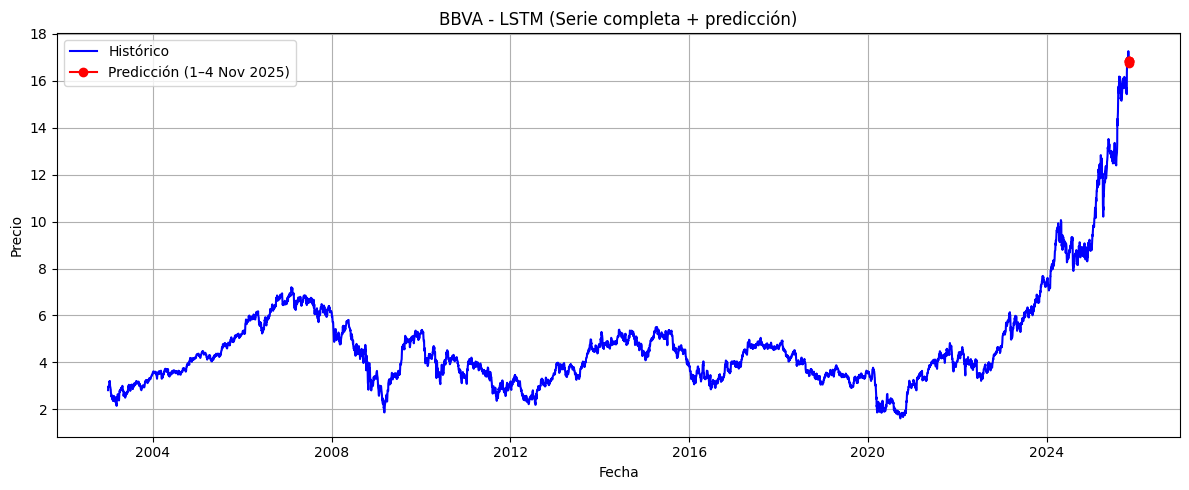

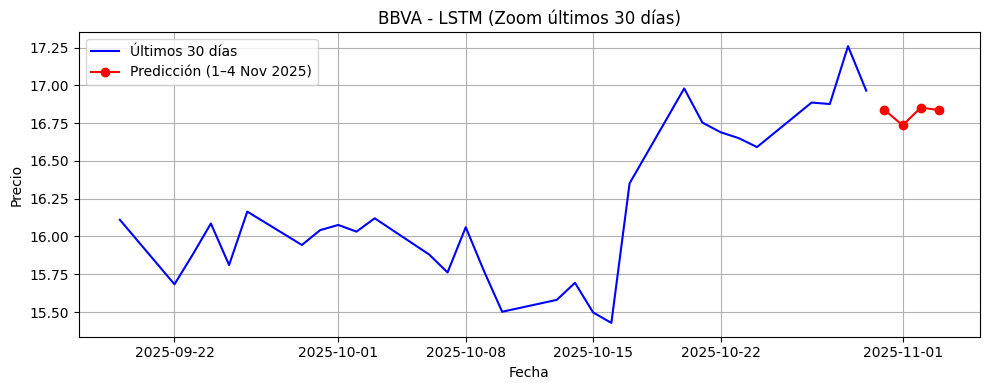


🔹 Entrenando modelo GRU para BBVA
Epoch 1/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0121

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0036
Epoch 2/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5213e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.4795e-04
Epoch 3/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4361e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.4352e-04
Epoch 4/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3711e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.3999e-04
Epoch 5/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3235e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.3541e-04
Epoch 6/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2884e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.3184e-04
Epoch 7/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2574e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.2870e-04
Epoch 8/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2328e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.2623e-04
Epoch 9/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2123e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.2413e-04
Epoch 10/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1965e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.2270e-04
Epoch 11/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1771e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.2112e-04
Epoch 12/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1708e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.2048e-04
Epoch 13/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1579e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.1920e-04
Epoch 14/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1511e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.1839e-04
Epoch 15/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1474e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.1783e-04
Epoch 16/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1408e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1731e-04
Epoch 17/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1330e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1651e-04
Epoch 18/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1306e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1640e-04
Epoch 19/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1273e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1593e-04
Epoch 20/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1199e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1543e-04
Epoch 21/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1543e-04
Epoch 22/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1215e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1528e-04
Epoch 23/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1198e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.1486e-04
Epoch 24/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1157e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.1458e-04
Epoch 25/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1145e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.1440e-04
Epoch 26/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1090e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1402e-04
Epoch 27/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1087e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1378e-04
Epoch 28/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1090e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.1361e-04
Epoch 29/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1056e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1349e-04
Epoch 30/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1055e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.1310e-04
Epoch 31/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1000e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.1296e-04
Epoch 32/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1037e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.1295e-04
Epoch 33/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1016e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 1.1273e-04
Epoch 34/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0996e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.1237e-04
Epoch 35/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0931e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.1210e-04
Epoch 36/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.1219e-04
Epoch 37/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0933e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.1188e-04
Epoch 38/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0932e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.1180e-04
Epoch 39/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0906e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.1143e-04
Epoch 40/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0869e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.1112e-04
Epoch 41/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.1113e-04
Epoch 42/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0840e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.1088e-04
Epoch 43/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0840e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.1080e-04
Epoch 44/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0805e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.1038e-04
Epoch 45/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0804e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.1036e-04
Epoch 46/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0795e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.1014e-04
Epoch 47/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0761e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.1001e-04
Epoch 48/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0782e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.0981e-04
Epoch 49/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0715e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.0944e-04
Epoch 50/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.0950e-04
Epoch 51/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0720e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.0928e-04
Epoch 52/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0709e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.0904e-04
Epoch 53/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.0912e-04
Epoch 54/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.0912e-04
Epoch 55/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0681e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.0880e-04
Epoch 56/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0658e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.0858e-04
Epoch 57/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.0876e-04
Epoch 58/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0685e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.0847e-04
Epoch 59/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0645e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.0831e-04
Epoch 60/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0647e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0827e-04
Epoch 61/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0636e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0814e-04
Epoch 62/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0632e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0809e-04
Epoch 63/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0632e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0796e-04
Epoch 64/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0621e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0793e-04
Epoch 65/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0615e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0771e-04
Epoch 66/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0602e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0759e-04
Epoch 67/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0589e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0743e-04
Epoch 68/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0580e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.0738e-04
Epoch 69/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0587e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0735e-04
Epoch 70/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0569e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0720e-04
Epoch 71/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0577e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0711e-04
Epoch 72/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0727e-04
Epoch 73/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0539e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0678e-04
Epoch 74/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0535e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0671e-04
Epoch 75/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.0681e-04
Epoch 76/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0545e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0670e-04
Epoch 77/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0529e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0656e-04
Epoch 78/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0528e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0646e-04
Epoch 79/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0646e-04
Epoch 80/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0652e-04


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


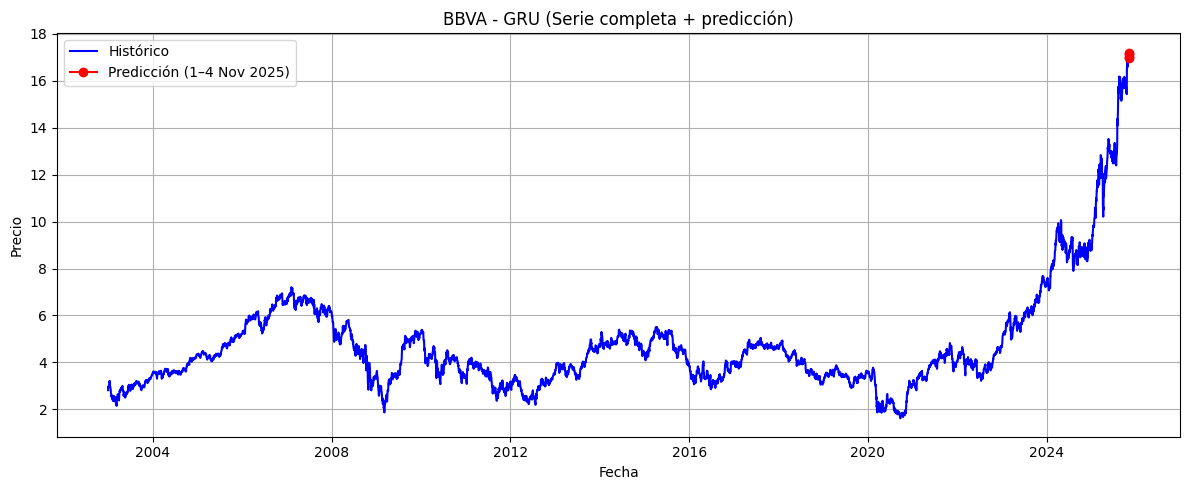

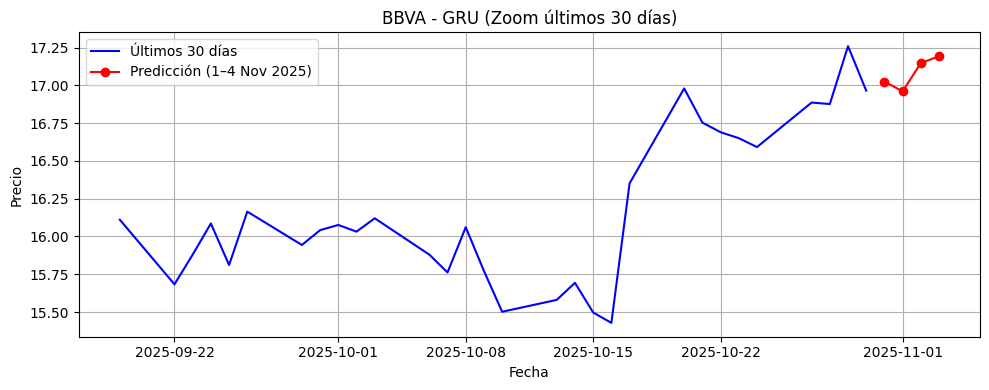

Entrenando modelos para SANTANDER con 5852 registros...

🔹 Entrenando modelo SimpleRNN para SANTANDER
Epoch 1/80
174/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0137

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0033
Epoch 2/80
171/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9447e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.8107e-04
Epoch 3/80
172/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3405e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.2849e-04
Epoch 4/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9833e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.9772e-04
Epoch 5/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7365e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.7521e-04
Epoch 6/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6259e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.6606e-04
Epoch 7/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5246e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.5345e-04
Epoch 8/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4171e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.4685e-04
Epoch 9/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.4768e-04
Epoch 10/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.4961e-04
Epoch 11/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.5154e-04
Epoch 12/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3037e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.3127e-04
Epoch 13/80
169/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1915e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1976e-04
Epoch 14/80
164/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1482e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1621e-04
Epoch 15/80
170/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1549e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1558e-04
Epoch 16/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0969e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1351e-04
Epoch 17/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0726e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1091e-04
Epoch 18/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0766e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0962e-04
Epoch 19/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0626e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0881e-04
Epoch 20/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0575e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0823e-04
Epoch 21/80
174/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0630e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0809e-04
Epoch 22/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0471e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0682e-04
Epoch 23/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0723e-04
Epoch 24/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0496e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0663e-04
Epoch 25/80
174/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0443e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0634e-04
Epoch 26/80
168/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0406e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0608e-04
Epoch 27/80
166/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0284e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0550e-04
Epoch 28/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0584e-04
Epoch 29/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.0552e-04
Epoch 30/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0572e-04
Epoch 31/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0238e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0516e-04
Epoch 32/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.0537e-04
Epoch 33/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0248e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0505e-04
Epoch 34/80
168/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0219e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.0503e-04
Epoch 35/80
169/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0198e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0474e-04
Epoch 36/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0502e-04
Epoch 37/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0235e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0464e-04
Epoch 38/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0528e-04
Epoch 39/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0200e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0431e-04
Epoch 40/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0434e-04
Epoch 41/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0500e-04
Epoch 42/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0178e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0411e-04
Epoch 43/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0414e-04
Epoch 44/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0209e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0409e-04
Epoch 45/80
173/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0202e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0389e-04
Epoch 46/80
173/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0171e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0358e-04
Epoch 47/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0369e-04
Epoch 48/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0395e-04
Epoch 49/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0117e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0347e-04
Epoch 50/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0091e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0344e-04
Epoch 51/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0049e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0272e-04
Epoch 52/80
168/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0046e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0237e-04
Epoch 53/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0340e-04
Epoch 54/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0050e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0233e-04
Epoch 55/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0236e-04
Epoch 56/80
173/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0058e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0225e-04
Epoch 57/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0016e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0208e-04
Epoch 58/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9970e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0154e-04
Epoch 59/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0157e-04
Epoch 60/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9959e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0118e-04
Epoch 61/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0154e-04
Epoch 62/80
174/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9933e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0096e-04
Epoch 63/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9908e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0071e-04
Epoch 64/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0089e-04
Epoch 65/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0097e-04
Epoch 66/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9909e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0026e-04
Epoch 67/80
169/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9904e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0008e-04
Epoch 68/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9901e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0006e-04
Epoch 69/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0017e-04
Epoch 70/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0096e-04
Epoch 71/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0080e-04
Epoch 72/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9789e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.9958e-04
Epoch 73/80
173/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9789e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.9920e-04
Epoch 74/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0015e-04
Epoch 75/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.9920e-04
Epoch 76/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.9960e-04
Epoch 77/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0008e-04
Epoch 78/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.9954e-04
Epoch 79/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.9966e-04
Epoch 80/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.9930e-04


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


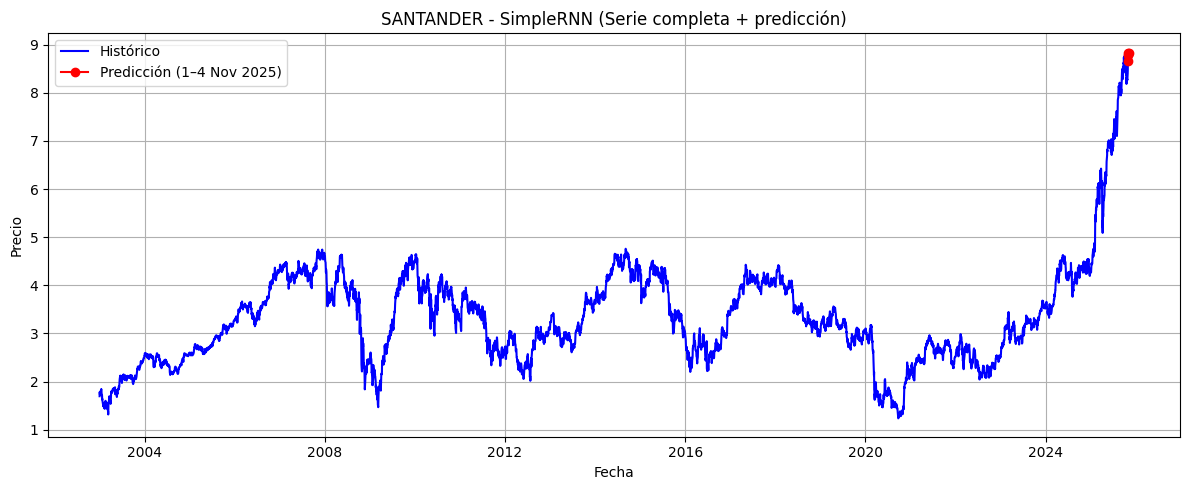

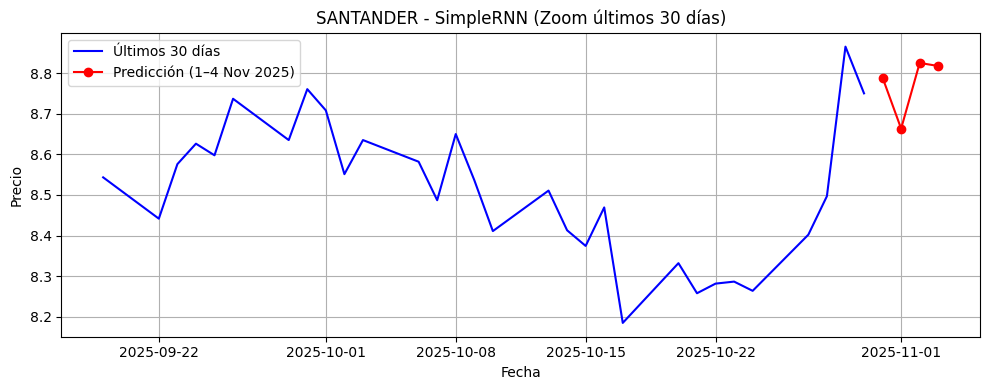


🔹 Entrenando modelo LSTM para SANTANDER
Epoch 1/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0206

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0062
Epoch 2/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7133e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.6020e-04
Epoch 3/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6283e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.6056e-04
Epoch 4/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.3518e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.3364e-04
Epoch 5/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.0985e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.1065e-04
Epoch 6/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9268e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.9375e-04
Epoch 7/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8007e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.8190e-04
Epoch 8/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.7011e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.7244e-04
Epoch 9/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6178e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.6449e-04
Epoch 10/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.5436e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.5803e-04
Epoch 11/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.5183e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.5359e-04
Epoch 12/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4486e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.4742e-04
Epoch 13/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.3966e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.4214e-04
Epoch 14/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.3384e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.3678e-04
Epoch 15/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3329e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.3428e-04
Epoch 16/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2891e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.3146e-04
Epoch 17/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.2651e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.2905e-04
Epoch 18/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.2297e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.2600e-04
Epoch 19/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.2188e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.2337e-04
Epoch 20/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1661e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.1963e-04
Epoch 21/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.1540e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.1936e-04
Epoch 22/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.1538e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.1805e-04
Epoch 23/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.1353e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.1667e-04
Epoch 24/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1282e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.1652e-04
Epoch 25/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1231e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.1459e-04
Epoch 26/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0961e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.1288e-04
Epoch 27/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0885e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.1234e-04
Epoch 28/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0818e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.1139e-04
Epoch 29/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0837e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.1137e-04
Epoch 30/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0785e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.1060e-04
Epoch 31/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0743e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.1019e-04
Epoch 32/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0685e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.0937e-04
Epoch 33/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0661e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.0909e-04
Epoch 34/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0637e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.0861e-04
Epoch 35/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0619e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.0832e-04
Epoch 36/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0575e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.0769e-04
Epoch 37/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0560e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.0735e-04
Epoch 38/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0514e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.0712e-04
Epoch 39/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.0760e-04
Epoch 40/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.0715e-04
Epoch 41/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0430e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.0569e-04
Epoch 42/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.0654e-04
Epoch 43/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.0619e-04
Epoch 44/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0315e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.0467e-04
Epoch 45/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0343e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.0461e-04
Epoch 46/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0287e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.0425e-04
Epoch 47/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0272e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.0413e-04
Epoch 48/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0249e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.0380e-04
Epoch 49/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.0406e-04
Epoch 50/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.0402e-04
Epoch 51/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0213e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.0321e-04
Epoch 52/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.0209e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0319e-04
Epoch 53/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.0190e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0301e-04
Epoch 54/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.0130e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0274e-04
Epoch 55/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.0164e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0259e-04
Epoch 56/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.0085e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0218e-04
Epoch 57/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0242e-04
Epoch 58/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.0104e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0203e-04
Epoch 59/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.0053e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0182e-04
Epoch 60/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0053e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0169e-04
Epoch 61/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9992e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0155e-04
Epoch 62/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9985e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.0120e-04
Epoch 63/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9961e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0088e-04
Epoch 64/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9960e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.0079e-04
Epoch 65/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9950e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0078e-04
Epoch 66/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9910e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.0044e-04
Epoch 67/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9908e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0035e-04
Epoch 68/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9914e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0021e-04
Epoch 69/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9881e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.0010e-04
Epoch 70/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9880e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.9994e-04
Epoch 71/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9845e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.9958e-04
Epoch 72/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9815e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.9955e-04
Epoch 73/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9823e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.9949e-04
Epoch 74/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9815e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.9936e-04
Epoch 75/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9796e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.9917e-04
Epoch 76/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9770e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.9893e-04
Epoch 77/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9759e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.9890e-04
Epoch 78/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9755e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.9881e-04
Epoch 79/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9724e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.9863e-04
Epoch 80/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9696e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.9845e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


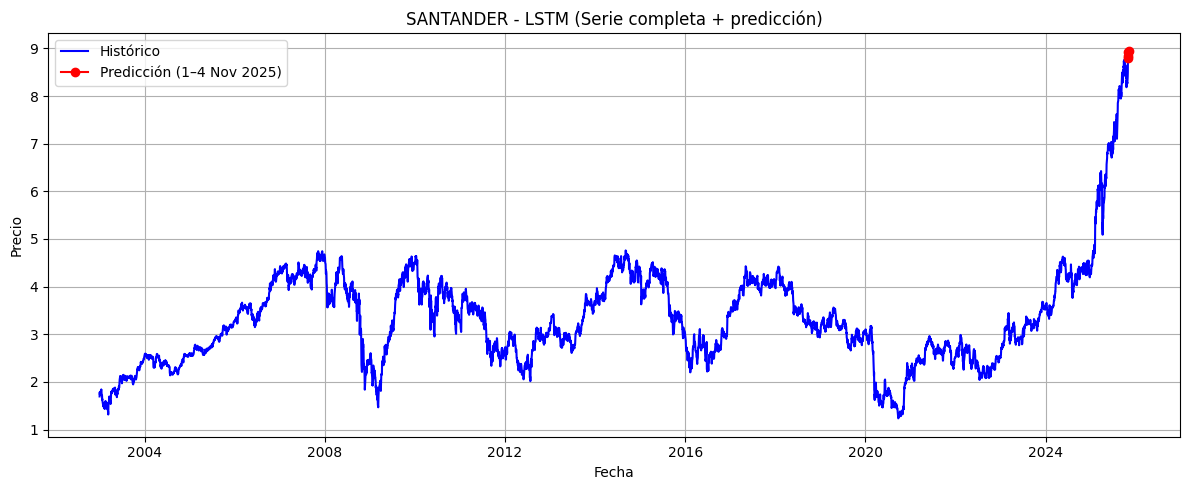

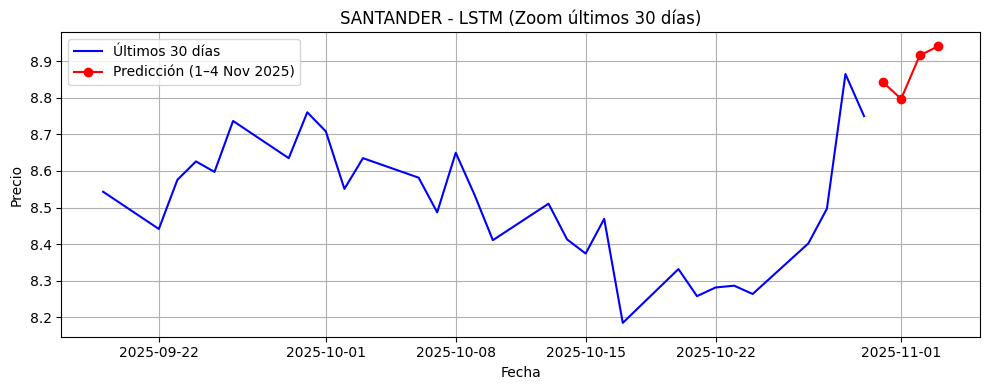


🔹 Entrenando modelo GRU para SANTANDER
Epoch 1/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0159

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0046
Epoch 2/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.4466e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.4273e-04
Epoch 3/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.3069e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.3008e-04
Epoch 4/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2378e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.2579e-04
Epoch 5/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1964e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.2321e-04
Epoch 6/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1698e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.2149e-04
Epoch 7/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.1453e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.1946e-04
Epoch 8/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1224e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.1732e-04
Epoch 9/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1034e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.1534e-04
Epoch 10/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0923e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.1398e-04
Epoch 11/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0818e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.1277e-04
Epoch 12/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0722e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.1163e-04
Epoch 13/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0677e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.1097e-04
Epoch 14/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0628e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.1027e-04
Epoch 15/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0584e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0961e-04
Epoch 16/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0537e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0900e-04
Epoch 17/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0491e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0852e-04
Epoch 18/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0477e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0822e-04
Epoch 19/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0439e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0768e-04
Epoch 20/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0408e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0737e-04
Epoch 21/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.0378e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.0716e-04
Epoch 22/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.0362e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.0702e-04
Epoch 23/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.0353e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.0662e-04
Epoch 24/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.0323e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.0659e-04
Epoch 25/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.0310e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.0622e-04
Epoch 26/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.0624e-04
Epoch 27/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.0286e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.0610e-04
Epoch 28/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.0270e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.0591e-04
Epoch 29/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.0273e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.0582e-04
Epoch 30/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.0583e-04
Epoch 31/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.0265e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.0577e-04
Epoch 32/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.0243e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2.0550e-04
Epoch 33/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.0555e-04
Epoch 34/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.0265e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.0544e-04
Epoch 35/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.0548e-04
Epoch 36/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.0249e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.0517e-04
Epoch 37/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0225e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.0505e-04
Epoch 38/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.0221e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2.0491e-04
Epoch 39/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0210e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.0481e-04
Epoch 40/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0201e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0472e-04
Epoch 41/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0184e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0443e-04
Epoch 42/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0169e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0433e-04
Epoch 43/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0162e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.0417e-04
Epoch 44/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0150e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0405e-04
Epoch 45/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0135e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.0386e-04
Epoch 46/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0127e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.0371e-04
Epoch 47/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0036e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0336e-04
Epoch 48/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0349e-04
Epoch 49/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0091e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0329e-04
Epoch 50/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0080e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0322e-04
Epoch 51/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0060e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.0302e-04
Epoch 52/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0050e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.0285e-04
Epoch 53/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0024e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0263e-04
Epoch 54/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0019e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0250e-04
Epoch 55/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0006e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0234e-04
Epoch 56/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9996e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0222e-04
Epoch 57/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9976e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0203e-04
Epoch 58/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9960e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0187e-04
Epoch 59/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9943e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0173e-04
Epoch 60/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0183e-04
Epoch 61/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9942e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0159e-04
Epoch 62/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9908e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0138e-04
Epoch 63/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9903e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0124e-04
Epoch 64/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9880e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.0114e-04
Epoch 65/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0132e-04
Epoch 66/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9875e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0107e-04
Epoch 67/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0116e-04
Epoch 68/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9839e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0079e-04
Epoch 69/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9820e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.0055e-04
Epoch 70/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9809e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.0051e-04
Epoch 71/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9802e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.0046e-04
Epoch 72/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9794e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.0040e-04
Epoch 73/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9779e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.0012e-04
Epoch 74/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9768e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.0002e-04
Epoch 75/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9758e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.9990e-04
Epoch 76/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9753e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.9986e-04
Epoch 77/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9749e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.9975e-04
Epoch 78/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9738e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.9974e-04
Epoch 79/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9726e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.9952e-04
Epoch 80/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.9963e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


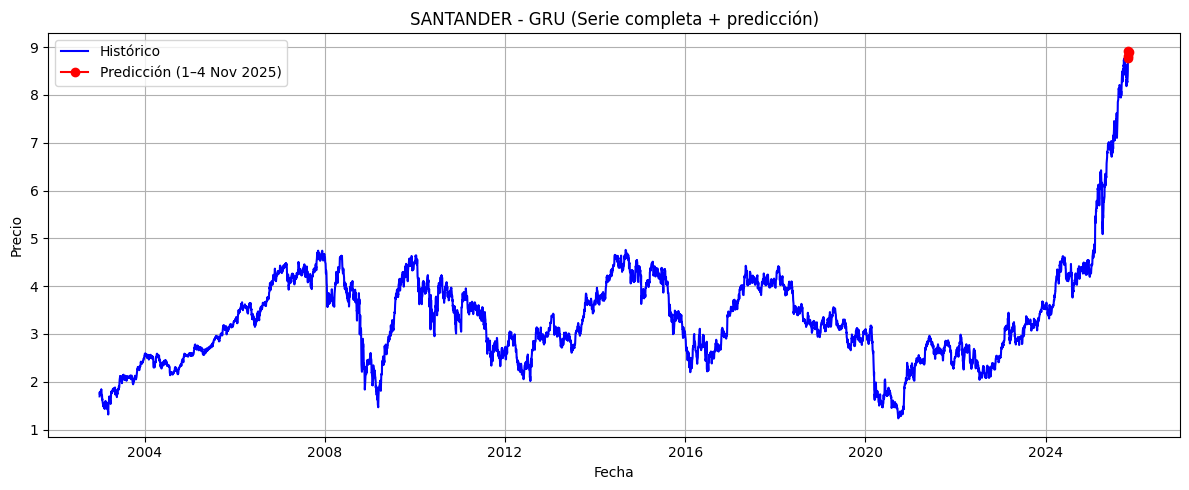

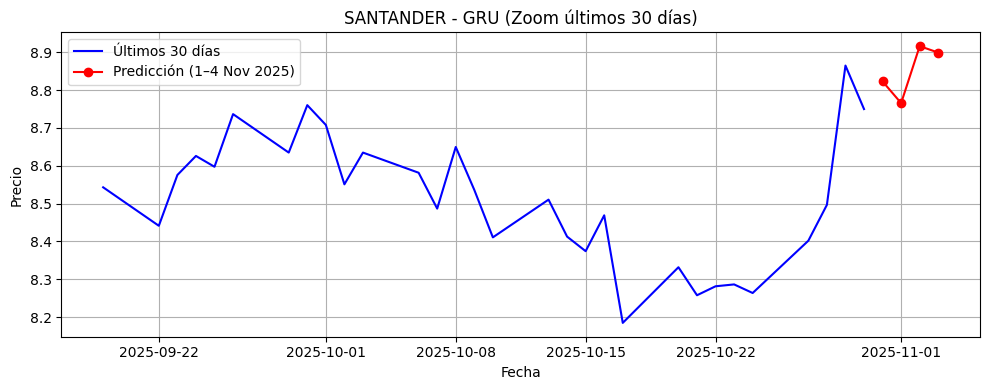


✅ Predicciones completadas. Modelos guardados en: modelos_prediccion_noviembre


In [132]:
# -------------------------------------------
# Celda: Predicción futura multi-step (versión ajustada a noviembre 2025)
# -------------------------------------------
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ---------- parámetros ----------
timesteps = 60
forecast_days = 4  # predicción 1–4 de noviembre 2025
epochs = 80
batch_size = 32
patience = 8
models_dir = "modelos_prediccion_noviembre"
os.makedirs(models_dir, exist_ok=True)

# ---------- cargar datos ----------
BBVA_data = pd.read_csv("bbva_completo.csv")
SANTANDER_data = pd.read_csv("santander_completo.csv")

# Se asume que las columnas son "Date" y "Close_XXX.MC"
BBVA_data['Date'] = pd.to_datetime(BBVA_data['Date'])
SANTANDER_data['Date'] = pd.to_datetime(SANTANDER_data['Date'])

# ---------- utilidades ----------
def create_sequences(series, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(series) - n_steps_in - n_steps_out + 1):
        X.append(series[i:i+n_steps_in])
        y.append(series[i+n_steps_in:i+n_steps_in+n_steps_out])
    X = np.array(X).reshape(-1, n_steps_in, 1)
    y = np.array(y)
    return X, y

def build_rnn(model_type='LSTM', n_steps_in=timesteps, n_steps_out=forecast_days, units=64):
    model = Sequential()
    if model_type == 'SimpleRNN':
        model.add(SimpleRNN(units, input_shape=(n_steps_in, 1)))
    elif model_type == 'GRU':
        model.add(GRU(units, input_shape=(n_steps_in, 1)))
    else:
        model.add(LSTM(units, input_shape=(n_steps_in, 1)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    return model

# ---------- función principal ----------
def train_and_predict(df_stock, stock_name):
    series = df_stock['Close'].dropna().values.reshape(-1, 1)
    dates = pd.to_datetime(df_stock['Date'].values)

    scaler = MinMaxScaler()
    series_scaled = scaler.fit_transform(series).flatten()

    X_train, y_train = create_sequences(series_scaled, timesteps, forecast_days)
    print(f"Entrenando modelos para {stock_name} con {len(series)} registros...")

    models = ['SimpleRNN', 'LSTM', 'GRU']
    results = {}

    # Usamos los últimos timesteps para hacer la predicción futura
    last_window = series_scaled[-timesteps:].reshape(1, timesteps, 1)

    for arch in models:
        print(f"\n🔹 Entrenando modelo {arch} para {stock_name}")
        model = build_rnn(model_type=arch)
        ckpt_path = os.path.join(models_dir, f"{stock_name}_{arch}_forecast.h5")

        callbacks = [
            EarlyStopping(monitor='loss', patience=patience, restore_best_weights=True),
            ModelCheckpoint(ckpt_path, monitor='loss', save_best_only=True, verbose=0)
        ]

        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            verbose=1,
            callbacks=callbacks
        )

        # Predicción de los próximos 4 días
        pred_scaled = model.predict(last_window).flatten()
        pred = scaler.inverse_transform(pred_scaled.reshape(-1,1)).flatten()

        # Generar nuevas fechas para 1-4 de noviembre 2025
        last_date = dates[-1]
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_days)

        # Guardar resultados
        results[arch] = {
            "model": model,
            "forecast": pred,
            "future_dates": future_dates,
            "ckpt_path": ckpt_path,
            "history": history.history
        }

        # -------- Gráfico 1: histórico completo + predicción --------
        plt.figure(figsize=(12,5))
        plt.plot(dates, series, label='Histórico', color='blue')
        plt.plot(future_dates, pred, 'ro-', label='Predicción (1–4 Nov 2025)')
        plt.title(f"{stock_name} - {arch} (Serie completa + predicción)")
        plt.xlabel("Fecha")
        plt.ylabel("Precio")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # -------- Gráfico 2: últimos 30 días + predicción --------
        plt.figure(figsize=(10,4))
        plt.plot(dates[-30:], series[-30:], label='Últimos 30 días', color='blue')
        plt.plot(future_dates, pred, 'ro-', label='Predicción (1–4 Nov 2025)')
        plt.title(f"{stock_name} - {arch} (Zoom últimos 30 días)")
        plt.xlabel("Fecha")
        plt.ylabel("Precio")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return results

# ---------- Ejecutar para BBVA y SANTANDER ----------
bbva_res = train_and_predict(
    BBVA_data[['Date', 'Close_BBVA.MC']].rename(columns={'Close_BBVA.MC': 'Close'}),
    "BBVA"
)

san_res = train_and_predict(
    SANTANDER_data[['Date', 'Close_SAN.MC']].rename(columns={'Close_SAN.MC': 'Close'}),
    "SANTANDER"
)

print("\n✅ Predicciones completadas. Modelos guardados en:", models_dir)


Univariado autoregresivo (GRU recursivo, predict-one-step & roll-forward)


===== Procesando BBVA (univar GRU recursivo) =====
Secuencias univar: (5792, 60, 1) (5792, 1)
Epoch 1/120
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0018 - mae: 0.0250

326/326 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 5.5607e-04 - mae: 0.0147 - val_loss: 9.7313e-04 - val_mae: 0.0247
Epoch 2/120
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.5991e-04 - mae: 0.0096

326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 1.3494e-04 - mae: 0.0089 - val_loss: 3.1917e-04 - val_mae: 0.0127
Epoch 3/120
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.0851e-04 - mae: 0.0078

326/326 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 1.1236e-04 - mae: 0.0080 - val_loss: 2.7831e-04 - val_mae: 0.0124
Epoch 4/120
326/326 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 9.4742e-05 - mae: 0.0073 - val_loss: 9.4887e-04 - val_mae: 0.0252
Epoch 5/120
326/326 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 8.6185e-05 - mae: 0.0070 - val_loss: 3.0677e-04 - val_mae: 0.0131
Epoch 6/120
326/326 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 8.0785e-05 - mae: 0.0069 - val_loss: 4.7430e-04 - val_mae: 0.0165
Epoch 7/120
326/326 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 7.9646e-05 - mae: 0.0068 - val_loss: 0.0014 - val_mae: 0.0317
Epoch 8/120
326/326 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 8.6456e-05 - mae: 0.0071 - val_loss: 4.5939e-04 - val_mae: 0.0161
Epoch 9/120
326/326 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 8.0554e-05 - mae: 0.0068 - val_loss: 5.7133e-04 - val_mae: 0.0196
Epoch 10/120
326/326 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 7.8589e-05 - mae: 0.0068 - val_loss: 5.8655e-04 - val_mae

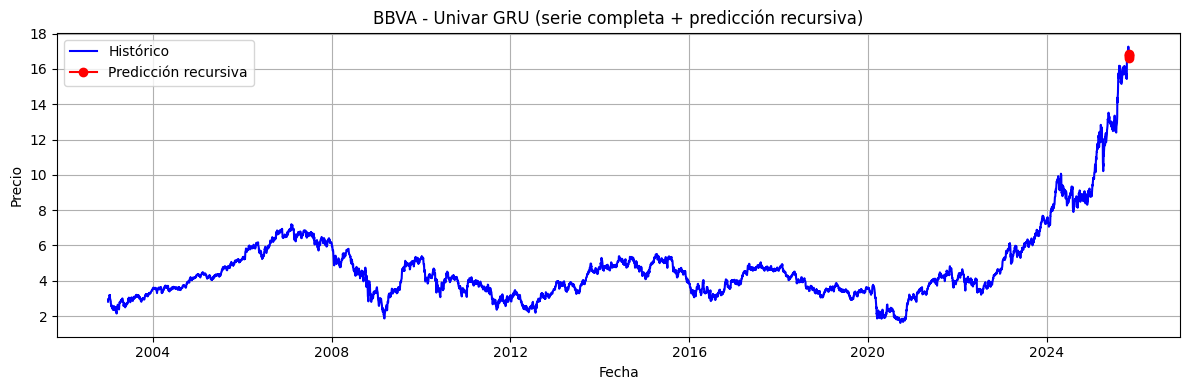

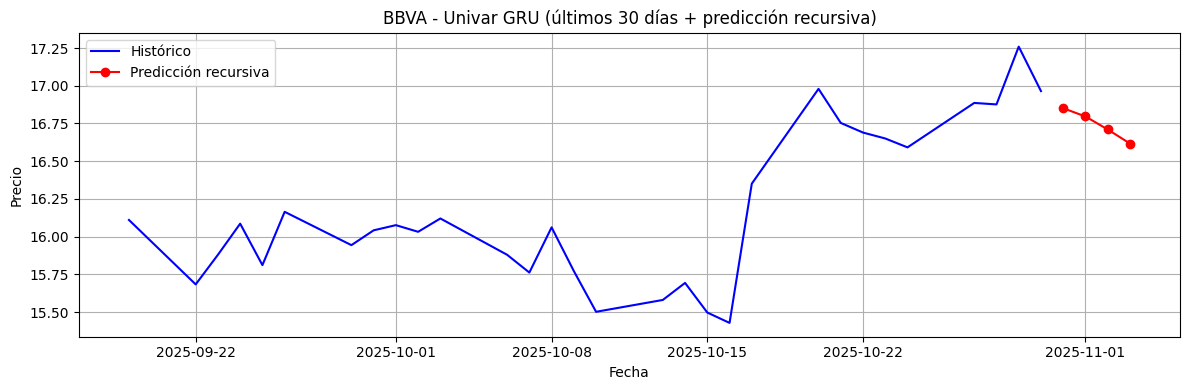


===== Procesando SANTANDER (univar GRU recursivo) =====
Secuencias univar: (5792, 60, 1) (5792, 1)
Epoch 1/120
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0046 - mae: 0.0393

326/326 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 0.0014 - mae: 0.0230 - val_loss: 3.8650e-04 - val_mae: 0.0144
Epoch 2/120
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.8597e-04 - mae: 0.0148

326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 3.4619e-04 - mae: 0.0141 - val_loss: 2.8600e-04 - val_mae: 0.0121
Epoch 3/120
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.6870e-04 - mae: 0.0125

326/326 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 2.5186e-04 - mae: 0.0120 - val_loss: 2.6154e-04 - val_mae: 0.0120
Epoch 4/120
326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 2.0919e-04 - mae: 0.0110 - val_loss: 3.1722e-04 - val_mae: 0.0127
Epoch 5/120
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.9366e-04 - mae: 0.0105

326/326 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 1.9166e-04 - mae: 0.0105 - val_loss: 2.1625e-04 - val_mae: 0.0105
Epoch 6/120
326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 1.7539e-04 - mae: 0.0101 - val_loss: 9.3378e-04 - val_mae: 0.0218
Epoch 7/120
326/326 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 1.7165e-04 - mae: 0.0100 - val_loss: 5.2909e-04 - val_mae: 0.0166
Epoch 8/120
326/326 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 1.5691e-04 - mae: 0.0096 - val_loss: 5.4130e-04 - val_mae: 0.0163
Epoch 9/120
324/326 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.6275e-04 - mae: 0.0097

326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 1.6663e-04 - mae: 0.0099 - val_loss: 2.0597e-04 - val_mae: 0.0106
Epoch 10/120
326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 1.7009e-04 - mae: 0.0100 - val_loss: 3.3663e-04 - val_mae: 0.0135
Epoch 11/120
326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 1.7217e-04 - mae: 0.0100 - val_loss: 2.7138e-04 - val_mae: 0.0123
Epoch 12/120
326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 1.7089e-04 - mae: 0.0100 - val_loss: 2.9606e-04 - val_mae: 0.0121
Epoch 13/120
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.5992e-04 - mae: 0.0096

326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 1.6404e-04 - mae: 0.0097 - val_loss: 1.7354e-04 - val_mae: 0.0096
Epoch 14/120
326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 1.4954e-04 - mae: 0.0094 - val_loss: 8.5398e-04 - val_mae: 0.0198
Epoch 15/120
326/326 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 1.5394e-04 - mae: 0.0095 - val_loss: 6.5448e-04 - val_mae: 0.0174
Epoch 16/120
326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 1.5743e-04 - mae: 0.0096 - val_loss: 3.8677e-04 - val_mae: 0.0139
Epoch 17/120
326/326 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 1.5749e-04 - mae: 0.0095 - val_loss: 3.5675e-04 - val_mae: 0.0134
Epoch 18/120
326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 1.6497e-04 - mae: 0.0098 - val_loss: 4.6715e-04 - val_mae: 0.0153
Epoch 19/120
326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 1.5126e-04 - mae: 0.0093 - val_loss: 6.6909e-04 - val_mae: 0.0175
Epoch 20/120
326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 1.5911e-04 - mae: 0.0097 - val_loss: 2.1078e-

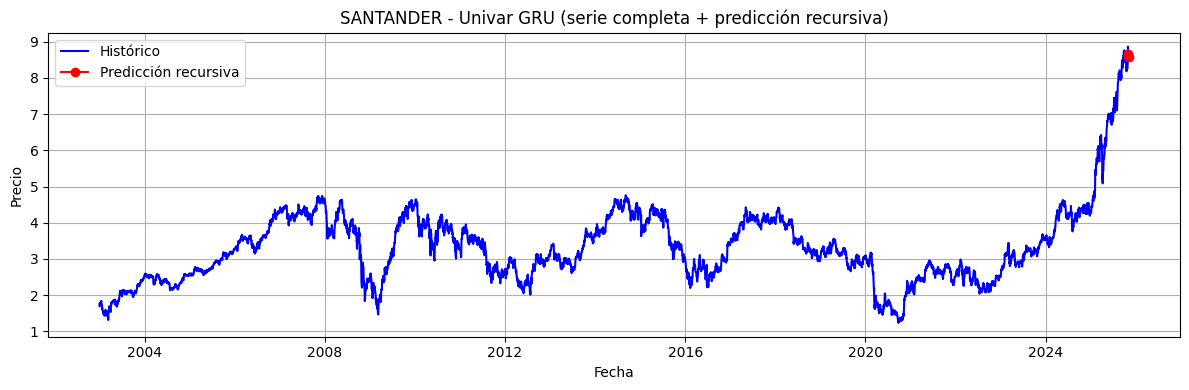

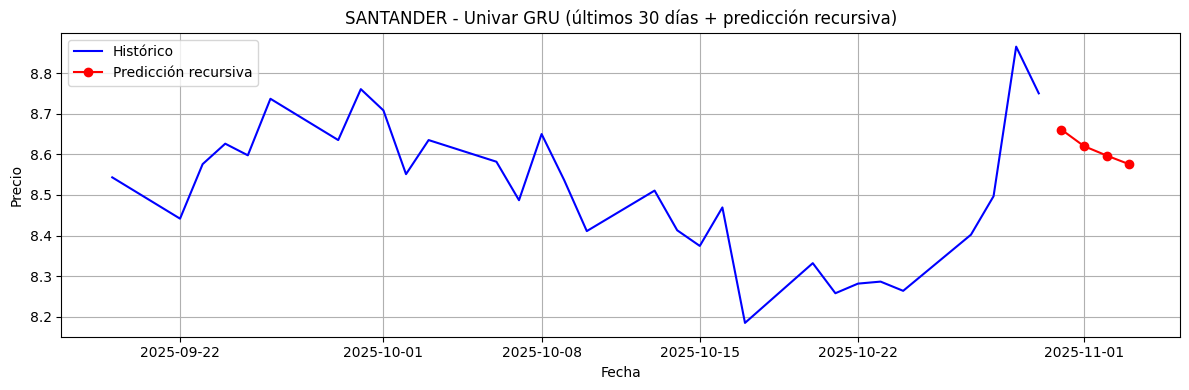


✅ Univar GRU recursivo completado. Predicciones guardadas en: predicciones_univariado_gru.csv


In [135]:
# archivo: pred_univariado_gru_recursivo.py
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K

# ---------- parámetros ----------
timesteps = 60
forecast_days = 4    # haremos 4 predicciones recursivas
epochs = 120
batch_size = 16
patience = 10
models_dir = "modelos_univariado_gru"
os.makedirs(models_dir, exist_ok=True)
pred_csv = "predicciones_univariado_gru.csv"

# ---------- cargar datos ----------
BBVA_data = pd.read_csv("bbva_completo.csv")
SANTANDER_data = pd.read_csv("santander_completo.csv")
for df in [BBVA_data, SANTANDER_data]:
    df['Date'] = pd.to_datetime(df['Date'])

# ---------- utilidades ----------
def create_sequences_univar(series, n_steps_in):
    X, y = [], []
    for i in range(len(series) - n_steps_in):
        X.append(series[i:i+n_steps_in])
        y.append(series[i+n_steps_in])
    X = np.array(X).reshape(-1, n_steps_in, 1)
    y = np.array(y).reshape(-1, 1)
    return X, y

def build_gru(n_steps_in, units=128, dropout=0.2):
    model = Sequential()
    model.add(GRU(units, return_sequences=True, input_shape=(n_steps_in, 1)))
    model.add(Dropout(dropout))
    model.add(GRU(units//2))
    model.add(Dropout(dropout))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def plot_forecast(dates, series, future_dates, preds, title):
    plt.figure(figsize=(12,4))
    plt.plot(dates, series, label='Histórico', color='blue')
    plt.plot(future_dates, preds, marker='o', linestyle='-', color='red', label='Predicción recursiva')
    plt.title(title); plt.xlabel('Fecha'); plt.ylabel('Precio')
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

def run_univariate(df, stock_name, close_col_name):
    print(f"\n===== Procesando {stock_name} (univar GRU recursivo) =====")
    df = df.sort_values('Date').reset_index(drop=True)
    if close_col_name not in df.columns:
        print("Columna close no encontrada:", close_col_name); return None
    df_sub = df[['Date', close_col_name]].dropna().reset_index(drop=True)
    df_sub = df_sub.rename(columns={close_col_name:'Close'})
    if df_sub.shape[0] < timesteps + 5:
        print("Datos insuficientes."); return None

    scaler = MinMaxScaler()
    series = df_sub['Close'].values.reshape(-1,1).astype(float)
    series_scaled = scaler.fit_transform(series).flatten()
    X, y = create_sequences_univar(series_scaled, timesteps)
    print("Secuencias univar:", X.shape, y.shape)

    # dividir train/val temporal (90/10)
    n_train = int(0.9 * len(X))
    model = build_gru(timesteps, units=128, dropout=0.2)
    ckpt = os.path.join(models_dir, f"{stock_name}_univar_gru.h5")
    callbacks = [EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=1),
                 ModelCheckpoint(ckpt, monitor='val_loss', save_best_only=True, verbose=0)]
    history = model.fit(X[:n_train], y[:n_train], validation_data=(X[n_train:], y[n_train:]),
                        epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=1)

    # predicción recursiva: partimos de la última ventana real
    last_window = series_scaled[-timesteps:].tolist()  # lista de length timesteps
    preds_inv = []
    preds_scaled = []
    for step in range(forecast_days):
        x_in = np.array(last_window[-timesteps:]).reshape(1, timesteps, 1)
        pred_scaled = model.predict(x_in).flatten()[0]
        preds_scaled.append(pred_scaled)
        # actualizar ventana con pred_scaled (recursivo)
        last_window.append(pred_scaled)
    preds_scaled = np.array(preds_scaled)
    preds_inv = scaler.inverse_transform(preds_scaled.reshape(-1,1)).flatten()

    last_date = df_sub['Date'].iloc[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_days)

    # guardar CSV
    recs = []
    for i, dt in enumerate(future_dates):
        recs.append({'stock':stock_name, 'model':'univar_gru_recursive', 'date':dt, 'pred':float(preds_inv[i])})
    pd.DataFrame(recs).to_csv(pred_csv, mode='a', header=not os.path.exists(pred_csv), index=False)

    # gráficos
    plot_forecast(df_sub['Date'], df_sub['Close'].values.flatten(), future_dates, preds_inv,
                  f"{stock_name} - Univar GRU (serie completa + predicción recursiva)")
    plot_forecast(df_sub['Date'].iloc[-30:], df_sub['Close'].values.flatten()[-30:], future_dates, preds_inv,
                  f"{stock_name} - Univar GRU (últimos 30 días + predicción recursiva)")

    K.clear_session()
    return {'model':model, 'forecast':preds_inv, 'future_dates':future_dates, 'ckpt':ckpt}

# ---------- ejecutar ----------
if __name__ == "__main__":
    # limpiar ficheros previos
    if os.path.exists(pred_csv):
        os.remove(pred_csv)
    run_univariate(BBVA_data, "BBVA", "Close_BBVA.MC")
    run_univariate(SANTANDER_data, "SANTANDER", "Close_SAN.MC")
    print("\n✅ Univar GRU recursivo completado. Predicciones guardadas en:", pred_csv)



LSTM optimizado con validación y reducción de ruido (diferenciación logarítmica)

Epoch 1/120
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0379

163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0120 - val_loss: 0.0023
Epoch 2/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 3/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 4/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 5/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 6/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 7/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 8/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 9/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 10/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0033

163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 11/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0033

163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 12/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0032

163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 13/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0032

163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 14/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0032

163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 15/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0032

163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 16/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0032

163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 17/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0032

163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 18/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0032

163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 19/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0032

163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 20/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 21/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0032

163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 22/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 23/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 24/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 25/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 26/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 27/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 28/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 29/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 30/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 31/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0033 - val_loss: 0.0022
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/

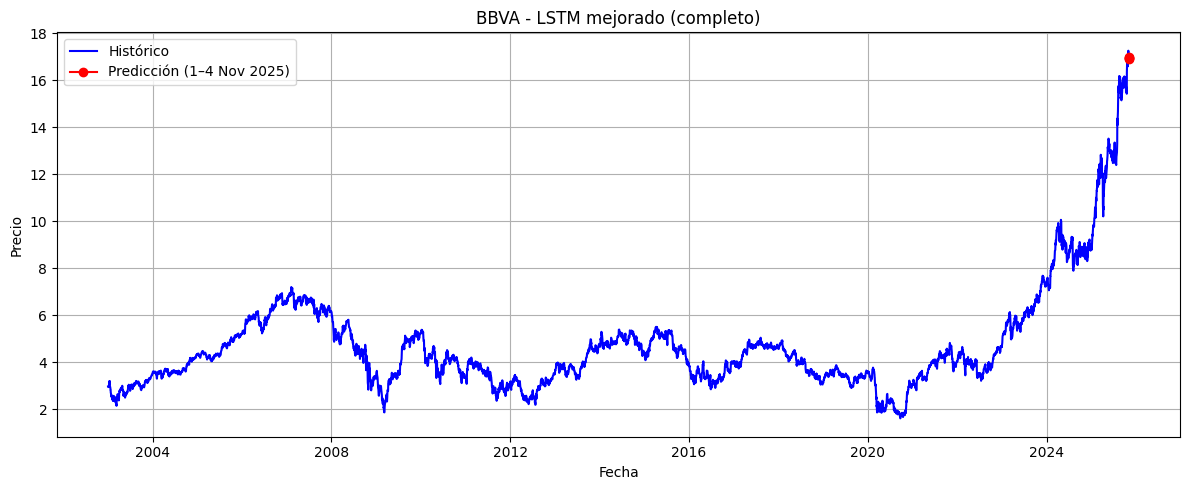

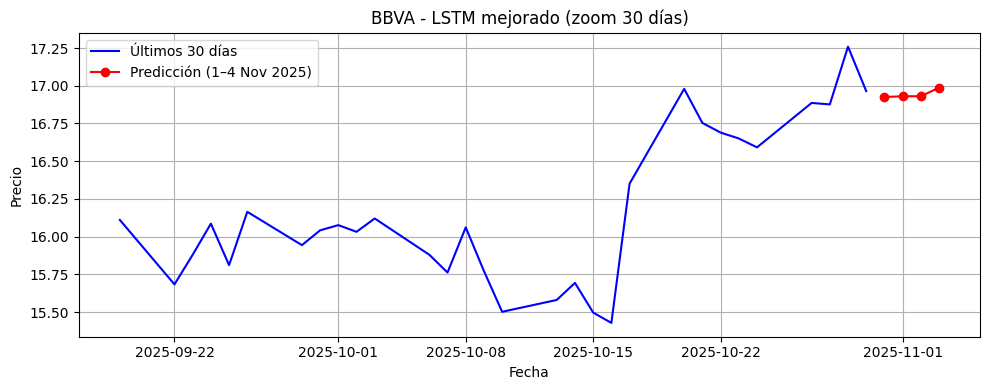

Epoch 1/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0388

163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0116 - val_loss: 0.0017
Epoch 2/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 3/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 4/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 5/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 6/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 7/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 8/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 9/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 10/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 11/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0026 - val_loss: 0.0018
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


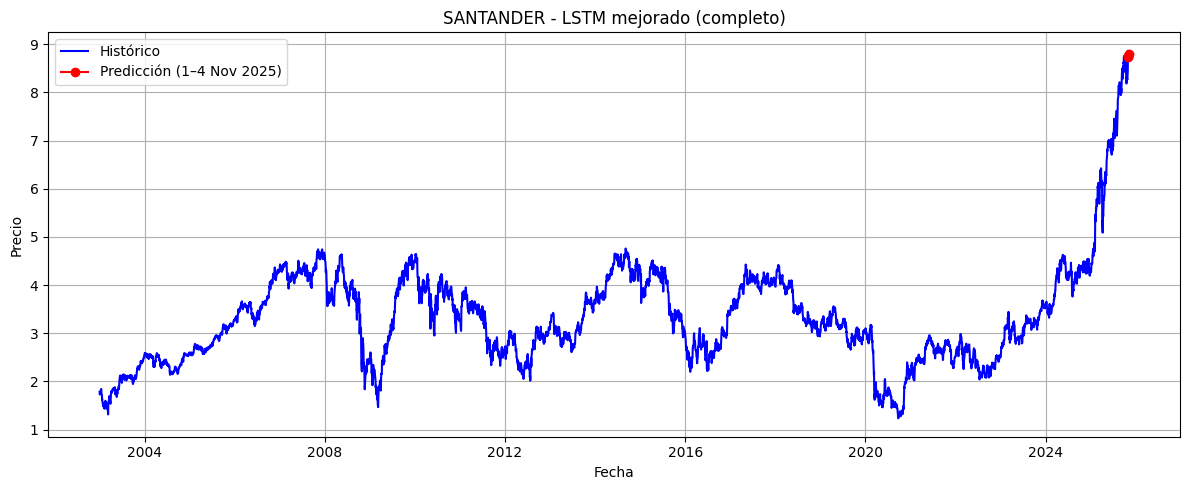

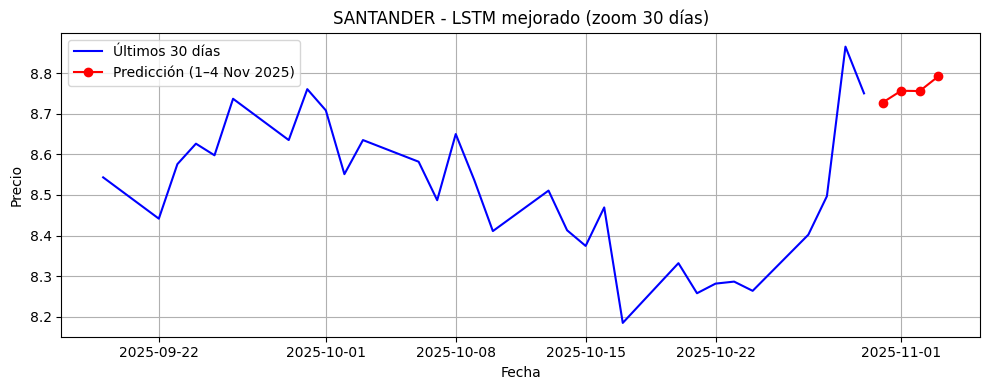


✅ Predicción completada con LSTM mejorado.


In [137]:
# -------------------------------------------
# LSTM mejorado con log-retornos + validación
# -------------------------------------------
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ---------- parámetros ----------
timesteps = 60
forecast_days = 4
epochs = 120
batch_size = 32
patience = 10
models_dir = "modelos_LSTM_mejorado"
os.makedirs(models_dir, exist_ok=True)

# ---------- cargar datos ----------
BBVA_data = pd.read_csv("bbva_completo.csv")
SANTANDER_data = pd.read_csv("santander_completo.csv")
for df in [BBVA_data, SANTANDER_data]:
    df['Date'] = pd.to_datetime(df['Date'])

# ---------- utilidades ----------
def create_sequences(series, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(series) - n_steps_in - n_steps_out + 1):
        X.append(series[i:i+n_steps_in])
        y.append(series[i+n_steps_in:i+n_steps_in+n_steps_out])
    X = np.array(X).reshape(-1, n_steps_in, 1)
    y = np.array(y)
    return X, y

def build_lstm(n_steps_in, n_steps_out):
    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=(n_steps_in, 1)),
        Dropout(0.2),
        LSTM(50),
        Dense(64, activation='relu'),
        Dense(n_steps_out)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def train_and_predict(df_stock, stock_name):
    df = df_stock.copy()
    df['Close'] = df['Close'].astype(float)
    df = df.dropna()
    df['Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df = df.dropna().reset_index(drop=True)

    series = df['Return'].values.reshape(-1, 1)
    dates = pd.to_datetime(df['Date'].values)

    scaler = MinMaxScaler()
    series_scaled = scaler.fit_transform(series).flatten()

    X, y = create_sequences(series_scaled, timesteps, forecast_days)
    n_train = int(0.9 * len(X))

    model = build_lstm(timesteps, forecast_days)
    ckpt_path = os.path.join(models_dir, f"{stock_name}_LSTM_mejorado.h5")

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True),
        ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=0)
    ]

    model.fit(
        X[:n_train], y[:n_train],
        validation_data=(X[n_train:], y[n_train:]),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=callbacks
    )

    last_window = series_scaled[-timesteps:].reshape(1, timesteps, 1)
    pred_scaled = model.predict(last_window).flatten()
    pred_returns = scaler.inverse_transform(pred_scaled.reshape(-1,1)).flatten()

    # Reconstruimos los precios a partir del último valor
    last_close = df['Close'].iloc[-1]
    pred_prices = [last_close * np.exp(sum(pred_returns[:i+1])) for i in range(forecast_days)]

    future_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=forecast_days)

    # Gráfico completo
    plt.figure(figsize=(12,5))
    plt.plot(dates, df['Close'], label='Histórico', color='blue')
    plt.plot(future_dates, pred_prices, 'ro-', label='Predicción (1–4 Nov 2025)')
    plt.title(f"{stock_name} - LSTM mejorado (completo)")
    plt.xlabel("Fecha"); plt.ylabel("Precio"); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()

    # Gráfico últimos 30 días
    plt.figure(figsize=(10,4))
    plt.plot(dates[-30:], df['Close'].iloc[-30:], label='Últimos 30 días', color='blue')
    plt.plot(future_dates, pred_prices, 'ro-', label='Predicción (1–4 Nov 2025)')
    plt.title(f"{stock_name} - LSTM mejorado (zoom 30 días)")
    plt.xlabel("Fecha"); plt.ylabel("Precio"); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()

    return pred_prices

# ---------- Ejecutar ----------
bbva_pred = train_and_predict(BBVA_data[['Date', 'Close_BBVA.MC']].rename(columns={'Close_BBVA.MC': 'Close'}), "BBVA")
san_pred  = train_and_predict(SANTANDER_data[['Date', 'Close_SAN.MC']].rename(columns={'Close_SAN.MC': 'Close'}), "SANTANDER")

print("\n✅ Predicción completada con LSTM mejorado.")


Bidirectional LSTM + GRU híbrido


🔹 Entrenando modelo híbrido para BBVA con 5788 secuencias...
Epoch 1/150
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0358

163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0156 - val_loss: 0.1623
Epoch 2/150
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0057

163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0055 - val_loss: 0.1045
Epoch 3/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0046

163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0046 - val_loss: 0.0508
Epoch 4/150
161/163 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0042

163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0042 - val_loss: 0.0133
Epoch 5/150
161/163 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0041

163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 6/150
161/163 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0040

163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 7/150
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0038

163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 8/150
161/163 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0037

163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 9/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0037 - val_loss: 0.0023
Epoch 10/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 11/150
161/163 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0035

163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 12/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0034

163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 13/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0034

163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 14/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 15/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 16/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0033

163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 17/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 18/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 19/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 20/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 21/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 22/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 23/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 24/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 25/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 26/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 27/150
163/163 ━━━━━━━━━━━━━

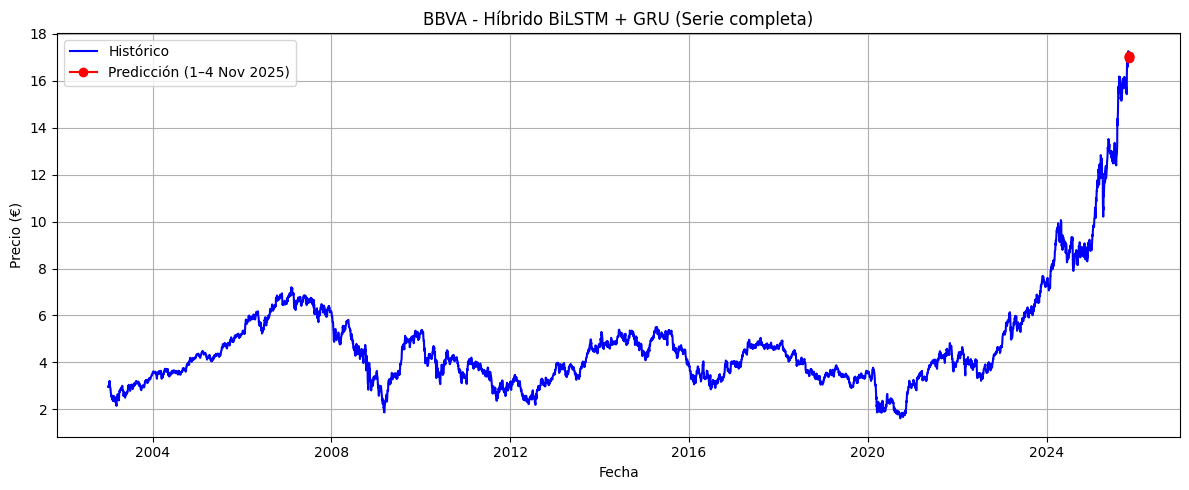

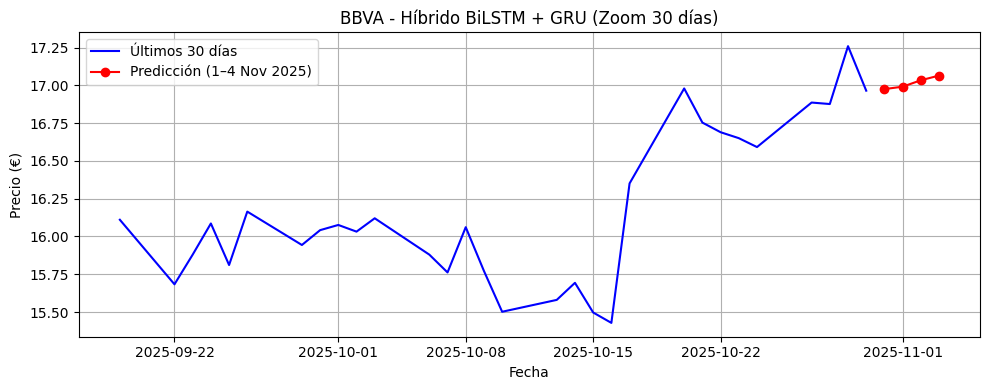


🔹 Entrenando modelo híbrido para SANTANDER con 5788 secuencias...
Epoch 1/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0249

163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0117 - val_loss: 0.1984
Epoch 2/150
161/163 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0047

163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0045 - val_loss: 0.1312
Epoch 3/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0041

163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0039 - val_loss: 0.0618
Epoch 4/150
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0037

163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0036 - val_loss: 0.0143
Epoch 5/150
161/163 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0034

163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 6/150
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0032

163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 7/150
161/163 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0032

163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 8/150
161/163 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0030

163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 9/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 10/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 11/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 12/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 13/150
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0027

163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 14/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 15/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 16/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 17/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 18/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 19/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 20/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 21/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 22/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 23/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 24/150
163/163 ━━━━━━━━━━━━━

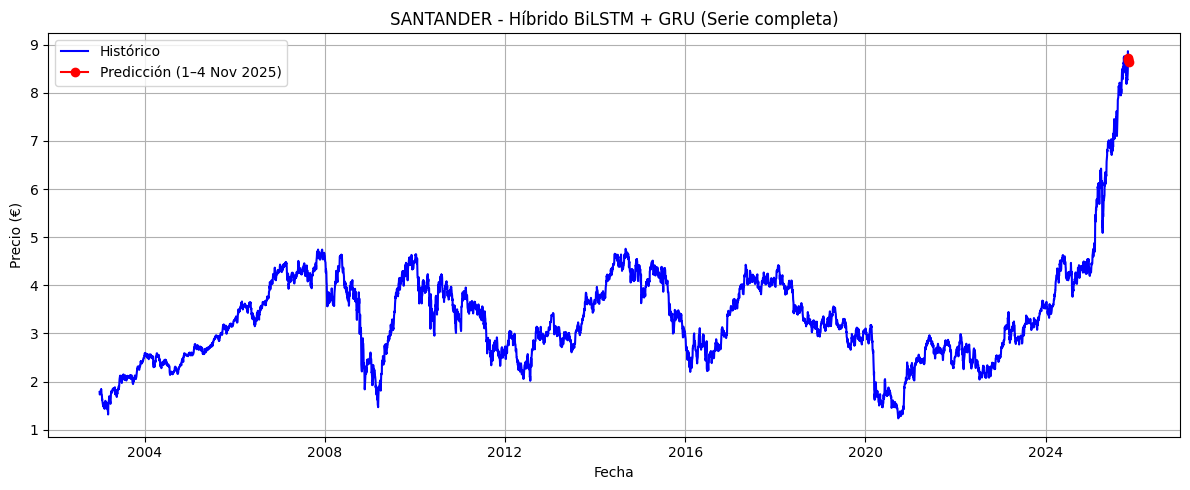

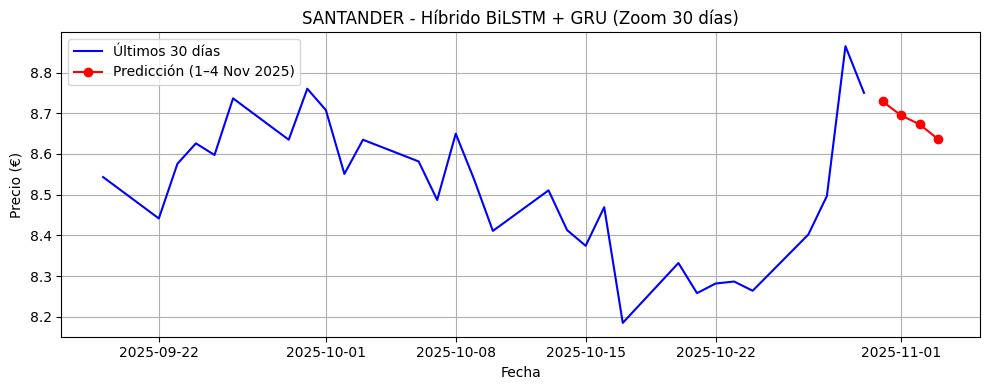


✅ Predicción híbrida completada. Modelos guardados en: modelos_hibrido_LSTM_GRU


In [139]:
# -------------------------------------------
# Modelo híbrido Bidirectional LSTM + GRU
# -------------------------------------------
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ---------- parámetros ----------
timesteps = 60
forecast_days = 4
epochs = 150
batch_size = 32
patience = 12
models_dir = "modelos_hibrido_LSTM_GRU"
os.makedirs(models_dir, exist_ok=True)

# ---------- cargar datos ----------
BBVA_data = pd.read_csv("bbva_completo.csv")
SANTANDER_data = pd.read_csv("santander_completo.csv")

for df in [BBVA_data, SANTANDER_data]:
    df['Date'] = pd.to_datetime(df['Date'])

# ---------- utilidades ----------
def create_sequences(series, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(series) - n_steps_in - n_steps_out + 1):
        X.append(series[i:i+n_steps_in])
        y.append(series[i+n_steps_in:i+n_steps_in+n_steps_out])
    X = np.array(X).reshape(-1, n_steps_in, 1)
    y = np.array(y)
    return X, y

def build_hybrid_model(n_steps_in, n_steps_out):
    model = Sequential([
        Bidirectional(LSTM(100, return_sequences=True), input_shape=(n_steps_in, 1)),
        Dropout(0.2),
        BatchNormalization(),
        GRU(80, return_sequences=False),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(n_steps_out)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def train_and_predict(df_stock, stock_name):
    df = df_stock.copy()
    df['Close'] = df['Close'].astype(float)
    df = df.dropna()
    df['Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df = df.dropna().reset_index(drop=True)

    series = df['Return'].values.reshape(-1, 1)
    dates = pd.to_datetime(df['Date'].values)

    scaler = MinMaxScaler()
    series_scaled = scaler.fit_transform(series).flatten()

    X, y = create_sequences(series_scaled, timesteps, forecast_days)
    n_train = int(0.9 * len(X))

    print(f"\n🔹 Entrenando modelo híbrido para {stock_name} con {len(X)} secuencias...")

    model = build_hybrid_model(timesteps, forecast_days)
    ckpt_path = os.path.join(models_dir, f"{stock_name}_Hibrido_LSTM_GRU.h5")

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True),
        ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=0)
    ]

    model.fit(
        X[:n_train], y[:n_train],
        validation_data=(X[n_train:], y[n_train:]),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=callbacks
    )

    # Predicción de los próximos 4 días
    last_window = series_scaled[-timesteps:].reshape(1, timesteps, 1)
    pred_scaled = model.predict(last_window).flatten()
    pred_returns = scaler.inverse_transform(pred_scaled.reshape(-1,1)).flatten()

    # Reconstrucción de precios a partir del último valor
    last_close = df['Close'].iloc[-1]
    pred_prices = [last_close * np.exp(sum(pred_returns[:i+1])) for i in range(forecast_days)]

    future_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=forecast_days)

    # -------- Gráfico 1: serie completa + predicción --------
    plt.figure(figsize=(12,5))
    plt.plot(dates, df['Close'], label='Histórico', color='blue')
    plt.plot(future_dates, pred_prices, 'ro-', label='Predicción (1–4 Nov 2025)')
    plt.title(f"{stock_name} - Híbrido BiLSTM + GRU (Serie completa)")
    plt.xlabel("Fecha"); plt.ylabel("Precio (€)")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

    # -------- Gráfico 2: últimos 30 días --------
    plt.figure(figsize=(10,4))
    plt.plot(dates[-30:], df['Close'].iloc[-30:], label='Últimos 30 días', color='blue')
    plt.plot(future_dates, pred_prices, 'ro-', label='Predicción (1–4 Nov 2025)')
    plt.title(f"{stock_name} - Híbrido BiLSTM + GRU (Zoom 30 días)")
    plt.xlabel("Fecha"); plt.ylabel("Precio (€)")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

    return pred_prices

# ---------- Ejecutar para BBVA y SANTANDER ----------
bbva_pred = train_and_predict(
    BBVA_data[['Date', 'Close_BBVA.MC']].rename(columns={'Close_BBVA.MC': 'Close'}),
    "BBVA"
)

san_pred = train_and_predict(
    SANTANDER_data[['Date', 'Close_SAN.MC']].rename(columns={'Close_SAN.MC': 'Close'}),
    "SANTANDER"
)

print("\n✅ Predicción híbrida completada. Modelos guardados en:", models_dir)
